# CasADi Tutorial

Implement your own MPC in 10 minutes! (once you know how to do it)

## Install CasADi

In [1]:
#!pip install casadi

## First steps with CasADi

In [2]:
# Import everything (*) from casadi
from casadi import *
# We also already import matplotlib for plotting:
import matplotlib.pyplot as plt
# And numpy because we cant live without numpy (it gives as matrices <3:
import numpy as np

In [3]:
# Define a symbol
x = SX.sym("x")
print(x)
# Any expression that uses a symbol is also a symbol
a = 3*x**2
print(a)
# You can define a vector of symbols of any size
y = SX.sym("y",5)
print(y)

x
(3*sq(x))
[y_0, y_1, y_2, y_3, y_4]


More information about CasADi in general and the available operations in particular can be found in this [List of Operations in CasADi](https://web.casadi.org/docs/#list-of-operations).


In [4]:
# Define a CasADi function
my_fun = Function('my_fun',[x],[x**2+5])
my_fun

Function(my_fun:(i0)->(o0) SXFunction)

The printed output reveals some information about the function: We have one input i0 and one output o0. We can also see that both input and output are scalar values, as CasADi would indicate vectors / matrices with their respective dimensions, e.g.:
```
Function(my_fun:(i0[3])->(o0) SXFunction)
```

Of course we can evaluate our function. The most straight-forward way to do so is to call it with an numerical input, e.g.:

In [5]:
# Evaluate your function numerically
my_fun(10)

DM(105)

Note that DM is the CasADi data type for numerical values. Further information can be found [here](https://web.casadi.org/docs/#dm). 
Sometimes it can be important to convert this back to the numpy format with:


```
DM(105).full()
```
Feel free to try this method with the function output above.


As we will see for the MPC application later, it is even more useful to evaluate the above function symbolically. This is also straight-forward:



In [6]:
# Evaluate your function symbolically
my_fun(x)
bb = SX.sym("bb")
my_fun(bb)

SX((sq(bb)+5))

## Task 01: Working with symbolic expressions
One of the main perks of working with symbolic CasADi expressions is the possibility to obtain exact derivatives of arbitrary expressions with **Automatic Differentiation**. We will not go into detail about AD in this exercise but simply explore the possibilites. <br>
1. Create a nested expression in a loop, where $$y_{k+1}=y_{k}\cdot sin(y_k)$$ and $y_0 = x$ for $k=0\dots10$. In the end you have a scalar expression: $$y_{10}=f(x)$$.
2. Print the expression y and investigate the output. Do you recognize the intermediate variables that are typical for the AD expression graph?


In [7]:
#create a symbolic expersion and use it to print the function above
x = SX.sym('x')
y = x
for k in range(10):
  y = y*np.sin(y)
  
print(y)

@1=(x*sin(x)), @2=(@1*sin(@1)), @3=(@2*sin(@2)), @4=(@3*sin(@3)), @5=(@4*sin(@4)), @6=(@5*sin(@5)), @7=(@6*sin(@6)), @8=(@7*sin(@7)), @9=(@8*sin(@8)), (@9*sin(@9))


3. Create a CasADi Function from this expression.
4. Use a simple numerical differentiation scheme such as:
$$ f'(x_0)\approx \frac{f(x_0+h)-f(x_0)}{h} $$
to determine the derivative for $x_0=7$ (what is the first number that comes to your mind??). See for example how the result changes with values of $h$, such as 1e-2, 1e-6, 1e-12, 1e-15, 1e-16

In [9]:
#create a new CasADi function that shows a derivative approximation
my_fun = Function('my_fun',[x],[y])

h = 1e-12
x0 = 7
dy = (my_fun(x0+h)-my_fun(x0))/h
print(dy)

-1779.78


Note how very different results are obtained. Also very small values of $h$ can create signifcant problems due to computer accuracy.

4. Now use AD to determine the gradient of the expression. See the [CasADi guide ](https://web.casadi.org/docs/#calculus-algorithmic-differentiation) for help.
5. Print the result again. Note that the resulting expression is much longer but still managable.

In [11]:
dy = gradient(y,x)
print(dy)

@1=sin(x), @2=(x*@1), @3=sin(@2), @4=(@2*@3), @5=sin(@4), @6=(@4*@5), @7=sin(@6), @8=(@6*@7), @9=sin(@8), @10=(@8*@9), @11=sin(@10), @12=(@10*@11), @13=sin(@12), @14=(@12*@13), @15=sin(@14), @16=(@14*@15), @17=sin(@16), @18=(@16*@17), @19=(sin(@18)+(cos(@18)*@18)), @20=((@17*@19)+(cos(@16)*(@16*@19))), @21=((@15*@20)+(cos(@14)*(@14*@20))), @22=((@13*@21)+(cos(@12)*(@12*@21))), @23=((@11*@22)+(cos(@10)*(@10*@22))), @24=((@9*@23)+(cos(@8)*(@8*@23))), @25=((@7*@24)+(cos(@6)*(@6*@24))), @26=((@5*@25)+(cos(@4)*(@4*@25))), @27=((@3*@26)+(cos(@2)*(@2*@26))), ((@1*@27)+(cos(x)*(x*@27)))


6. Create a CasADi Function from this expression and evaluate it for the same $x_0$ value:

In [12]:
dy_fun = Function('dy',[x],[dy])

dy_fun(x0)

DM(-1779.57)

**Optional Task:** Time the execution time of the two different methods. <br>
This can be done easily in this notebook by adding the **%%timeit** expression to any block of code, e.g.:


```python
%% timeit
for i in range(10000):
  i**2
```
We see something in the neighborhood of 7.75 us for the AD method and 44.2 us for the finite differences.

In [13]:
%%timeit
dy_fun(x0)

36.1 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
dy = (my_fun(x0+h)-my_fun(x0))/h

190 µs ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Define a linear system as a CasADi function

We define a simple linear system in discrete-time state-space form such that:
$$ x_{k+1} = Ax_{k}+Bu_{k}$$
where $x\in \mathbb{R}^n$, are the states of the system
and $u \in \mathbb{R}^m$ are the inputs.
The subscript $k$ and $k+1$ respectively, denote the discrete time instance of these variables.

The state space system is defined in terms of the **system matrix** $A\in \mathbb{R}^{n\times n}$ and the **input matrix** $B\in \mathbb{R^{n\times m}}$.

**Insert here your identified matrices!**

In [15]:
# System matrix:
A = np.array([[ 7.35792504e-01, -8.97123323e-02],
             [1.65904196e-01, 9.28984662e-01]])
nx = A.shape[1]
print(A)
print('A.shape = {}'.format(A.shape))

[[ 0.7357925  -0.08971233]
 [ 0.1659042   0.92898466]]
A.shape = (2, 2)


In [16]:
# The input matrix is defined as
B = np.array([[0.0035, 0.0],
             [0.0, 0.002]])
nu = B.shape[1]
print(B)
print('B.shape = {}'.format(B.shape))

[[0.0035 0.    ]
 [0.     0.002 ]]
B.shape = (2, 2)


In [15]:
# Matrix for external factors: (in your case it should have the shape 2x3)
E = np.array([[3.29610440e-01, 5.55032034e-02, 4.45751428e-05],
             [-1.80124486e-01, 5.45859756e-02, -5.80313372e-05]])

nd = E.shape[1]
print(E)
print('E.shape = {}'.format(E.shape))

[[ 3.29610440e-01  5.55032034e-02  4.45751428e-05]
 [-1.80124486e-01  5.45859756e-02 -5.80313372e-05]]
E.shape = (2, 3)


## Task 02: Investigate the stability of the proposed system

Next we investigate the stability of the presented system. 

1. Determine the Eigenvalues of the system matrix. <br>
**On a sidenote**: You can trigger the help / doc string of any function simply by writing:
```
np.linalg.eig?
```
2. What is the stability region of time-discrete state-space systems?
3. Plot or compare the eigenvalues with the stability criteria.

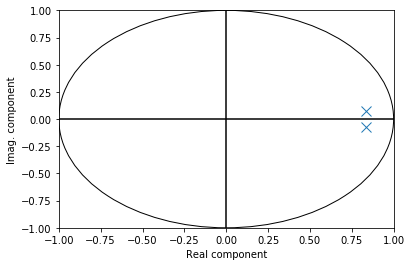

In [16]:
# Check the eigenvalues of the uncontrolled system (u = 0).
# You can check available methods by pressing TAB after "."
lam, v = np.linalg.eig(A)
# Note that you obtain here the eigenvalues and the eigenvectors
plt.xlabel('Real component')
plt.ylabel('Imag. component')
plt.gca().add_artist(plt.Circle((0, 0), 1,edgecolor='k', fill=False))
plt.plot(np.real(lam),np.imag(lam),'x', markersize=10)
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

The stability region of a discrete-time system is **within the unit circle**. As the eigenvalues lay directly on this circle, we can conclude that the system is stable but **not** asymptotically stable. 

## Task 03: Create a symbolic expression of the state-space system

We can also evalute the state-space system symbolically:
1. Create symbolic variables x and u with their respective dimension. Note that we already created the variables nx and nu above.

In [17]:
# Define state, input and external factors as CasADi symbols
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)
d = SX.sym("d",nd,1)

2. Create an symbolic expression for $x_{k+1}$ and a Function that takes two inputs ($x_k$, $u_k$) and returns $x_{k+1}$. This function should be named **system**:
```python
system = Function(...)
```

You may need to have a look at this list of [CasADi operations.](https://web.casadi.org/docs/#list-of-operations). An even more complete list can be found [here](https://web.casadi.org/python-api/). Note also that some numpy operations, such as np.sin work. 


In [18]:
# Define the dynamics as a CasADi expression
output_sys = A@x + B@u + E@d
print(output_sys)
print(output_sys.shape)
# Create the CasADi function
system = Function("sys",[x,u,d],[output_sys])

[((((0.735793*x_0)+(-0.0897123*x_1))+(0.0035*u_0))+(((0.32961*d_0)+(0.0555032*d_1))+(4.45751e-005*d_2))), ((((0.165904*x_0)+(0.928985*x_1))+(0.002*u_1))+(((-0.180124*d_0)+(0.054586*d_1))+(-5.80313e-005*d_2)))]
(2, 1)


3. Run the following code and see if it returns:
```
DM([1.47114, 0.560928, 1.67764, 0.865112])
```




In [19]:
x0 = np.ones((nx,1))
u0 = np.ones((nu,1))
d0 = np.ones((nd,1))
system(x0,u0,d0)

DM([1.03474, 0.971292])

## Task 04: Simulate a linear system
1. Run the following block of code to define the initial condition of x, the control input u (constant for all times). Furthermore, we create the solution arrays mpc_x and mpc_u and set the initial condition:

In [20]:
# Define the total steps to simulate
k_end = 50
# Define the initial condition
x_init = np.array([[22,50]])
# Define the input (for the moment consider u = 0)
u_sim = np.array([[0]])
d_sim = np.zeros((nd,1))
# Define arrays to store the results
mpc_x = np.zeros((k_end + 1, nx))
mpc_u = np.zeros((k_end, nu))
mpc_x[0,:] = x_init

2. Loop over the simulation steps, evaluate the update equation and save the new states and new inputs. Dont forget to reset x_init.

In [21]:
# Loop over the steps to simulate
for i in range(k_end):
  x_next = system(x_init,u_sim,d_sim)
  mpc_x[i+1,:] = x_next.T
  mpc_u[i,:] = u_sim.T
  x_init = x_next
  

## Plotting the results

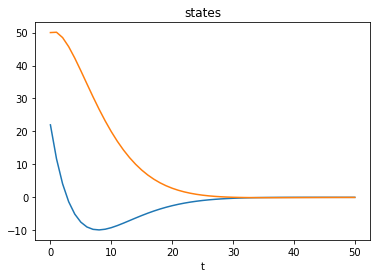

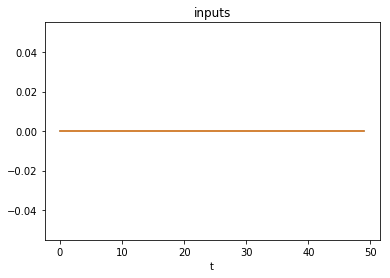

In [22]:
# plot the states
plt.figure(1)
plt.hold = True;
for k in range(mpc_x.shape[1]):
  plt.plot(mpc_x[:,k])
plt.title('states')
plt.xlabel('t')

# plot the inputs
plt.figure(2)
plt.hold = True;
for k in range(mpc_u.shape[1]):
  plt.plot(mpc_u[:,k])
plt.title('inputs')
plt.xlabel('t')

# show the plots
plt.show()

# MPC Tutorial

In this section we will formulate and run the MPC problem to regulate the system that was introduced above. Regulation means that the states are brought to zero. To achieve this goal we use a very common quadratic cost function, where for every time step k of the horizon the following expression should be minimized:

$$J(x_k) = x_k^T Q x_k + u_k^T R u_k $$

where Q and R are positive definite diagonal matrices. 
For the terminal cost we have a slightly altered expression, except that $u_N$ does not exist:

$$ J_T(x_N) = x_N^T Q x_N $$ 

## Define the optimization variables for MPC

In [23]:
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)
d = SX.sym("d",nd,1)

## Choose the tuning of MPC
You may want to come back to this, to see how it effects the results.

In [24]:
#@title Choose tuning parameter Q
Q = 1 #@param {type:"slider", min:0, max:100, step:1}
Q = np.diag(np.zeros(nx)*Q)
print(Q)

[[0. 0.]
 [0. 0.]]


In [25]:
#@title Choose tuning parameter R
R = np.array([[1, 0],
             [0, 1]])#@param {type:"slider", min:0, max:100, step:1}
#R = np.diag(np.ones(nu)*R)
print(R)

[[1 0]
 [0 1]]


In [26]:
#@title Choose prediction horizon N
N = 100 #@param {type:"slider", min:1, max:15, step:1}


In [27]:
#@title Choose number of steps S
S = 272*2-N #@param {type:"slider", min:1, max:100, step:1}


### Construct CasADi objective function

In [28]:
### state cost (function of x_k and u_k)
J_stage_exp = x.T@Q@x+ u.T@R@u
J_stage = Function('J_stage',[x,u],[J_stage_exp])

### terminal cost (function of x_N)
J_terminal_exp = x.T@Q@x
J_terminal = Function('J_terminal',[x],[J_terminal_exp])

## Define optimization variables

Note that the upper case variables **X** and U are stacked vectors that contain the states and inputs for all time-steps. Also note that X contains one element more than U.

In [29]:
X = SX.sym("X",(N+1)*nx,1)
U = SX.sym("U",N*nu,1)
D = SX.sym("D",N*nd,1)

## Define constraints

In [46]:
# state constraints, give here reasonable temperature and humidity ranges
lbx = np.array([[20],[40]])
ubx = np.array([[24],[70]])
# input constraints
#@title Choose input constraints u_ext
u_ext = 100000 #@param {type:"slider", min:0, max:3, step:0.1}
lbu = np.array([[-10000], [-10000]])
ubu = np.array([[10000], [10000]])

## Initialize vectors and matrices

In [47]:
# load here your external variables (solar radiation, ambient humidity and ambient temperature in mpc_d)
x_init = np.array([22, 50])
mpc_x = np.zeros((S+1,nx))
mpc_x[0,:] = x_init.T
mpc_u = np.zeros((S,nu))
mpc_d = np.zeros((S,nd))

## Task 05: Formulate MPC optimization problem
For this task you will have a slightly stricter format where you will add sections to the follwing code highlighted with:

```
###[Your code here!][01]
x = 
...
###[01]
```
Where [01] references question 01.
We will often start by naming the variables, because they may be used in later sections that are already existing.

---


Before you start coding, it is important to clearify the approach. We have already created the optimization variables **X** and **U**, which contain all $x_k\  \mathrm{for} \ k=0\dots N$ and $u_k\  \mathrm{for} \ k=0\dots N-1$. 
We optimize over both sets of variables simultaneously (hence this is called simultaneous approach).<br>
However, these variables cannot be choosen at free will. There is a relationship between $x_{k+1}$ and $x_{k}, u_{k}$ in the form of the system model. Furthermore, the initial state is fixed, such that $x_0 = x_{\mathrm{init}}$.

Your tasks:
1. Use indexation to query the right elements of X and U for the following values:
  - x_k
  - x_k_next
  - u_k
2. Add the cost of the current stage to the stage cost. Note that we defined a function "J_stage" earlier.
3. Evaluate the system equation symbolically to determine x_next. Use the values that were obtained in 01.
4. For the first step (k=0), add the equality constraint that $x_0 = x_{\mathrm{init}}$.
5. For all other steps (k>0), add the equality constraint that x_k_next = x_next. **Note** that only "G" can contain symbolic expressions and lbg, ubg must contain numerical values.


Make sure you understand the rest of the code. 

In [48]:
### formulate optimization problem
# Initialize zero cost and empty lists for bounds.
J = 0 
lb_X = [] # lower bound for X.
ub_X = [] # upper bound for X
lb_U = [] # lower bound for U
ub_U = [] # upper bound for U
G = []    # constraint expression G
lbg = []  # lower bound for constraint expression G
ubg = []  # upper bound for constraint expression G

###
for k in range(N):
    ### [Your code here!][01]
    x_k = X[k*nx:(k+1)*nx,:]
    x_k_next = X[(k+1)*nx:(k+2)*nx,:]
    u_k = U[k*nu:(k+1)*nu,:]
    d_k = D[k*nd:(k+1)*nd,:]
    ### [01]

    ### [Your code here!][02]
    # objective
    J += J_stage(x_k,u_k)
    ### [02]
    
    ### [Your code here!][03]
    # equality constraints (system equation)
    x_next = system(x_k,u_k,d_k)
    ### [03]

    ### [Your code here!][04]
    if k == 0:
        G.append(x_k)
        lbg.append(x_init)
        ubg.append(x_init)
    ### [04]

    ### [Your code here!][05]
    G.append(x_next - x_k_next)
    lbg.append(np.zeros((nx,1)))
    ubg.append(np.zeros((nx,1)))
    ### [05]

    # inequality constraints
    lb_X.append(lbx)
    ub_X.append(ubx)
    lb_U.append(lbu)
    ub_U.append(ubu)
    
## Terminal cost and constraints
x_k = X[N*nx:(N+1)*nx,:]
J += J_terminal(x_k)
lb_X.append(lbx)
ub_X.append(ubx)


lb = vertcat(vertcat(*lb_X),vertcat(*lb_U))
ub = vertcat(vertcat(*ub_X),vertcat(*ub_U))
prob = {'f':J,'x':vertcat(X,U),'p':vertcat(D),'g':vertcat(*G)}
solver = nlpsol('solver','ipopt',prob)

# Investigate solver object:
solver

Function(solver:(x0[402],p[300],lbx[402],ubx[402],lbg[202],ubg[202],lam_x0[402],lam_g0[202])->(x[402],f,g[202],lam_x[402],lam_g[202],lam_p[300]) IpoptInterface)

## MPC loop
The solver object that was created in the previous code snippet can now be called with the respective inputs that are shown above. We need to provide (see dimensions above):
- **x0:** This is not the state but the initial guess for the optimization variables. As you can see above we concatenate (X,U) to the optimization variable. **Optional Parameter**.
- **lbx:** Lower bounds to both states and control inputs (the conjoined optimization variables). These are defined already.
- **ubx:** Upper bounds to both states and control inputs (the conjoined optimization variables). These are defined already.
- **lbg:** Lower bounds to the the expression in "G". As "G" contains only equality constraints, both upper and lower bounds are set to the same value.
- **ubg:** Upper bounds to the the expression in "G". As "G" contains only equality constraints, both upper and lower bounds are set to the same value.

We use **lbg** and **ubg** to resest the initial condition. As we defined ```G[0]=x_0``` above, we simply set:


```
lbg[0]=x_init
ubg[0]=x_init
```


---

The output from the optimization is saved in a dictionary ```res``` with:


```
res.keys() 
> dict_keys(['f', 'g', 'lam_g', 'lam_p', 'lam_x', 'x'])

```

We are interested in the optimal solution x which, again, consists of both, the states ((N+1)*nx elements) and the inputs.
Upon querying the inputs we can simulate the system, as above.



---


**Questions:** 
- Do we need to manually simulate the system? 
- If not, why is it still a good idea / good practice to do so? 
- Does that reason apply here?


(3, 544)


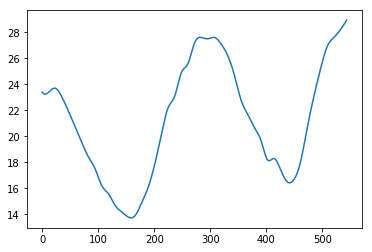

In [69]:
#getting our personal data for the MPC system
import csv
from scipy.interpolate import interp1d

#reading data from pysense csv
results = []
with open("June06-07RoomData\cleanMachine5DataJune06-07.csv") as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
results = np.array(results[1:])#removing header row
#casting to float
data = []
for r in results:
    arr = []
    for c in r:
        arr.append(float(c))
    data.append(arr)
data = np.array(data).T
data = np.concatenate([data,data],1)

#reading data from online weather csv
weatherInput = []
with open("June06-07RoomData\onlineWeatherData.csv") as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    for row in reader: # each row is a list
        weatherInput.append(row)
weatherInput = np.array(weatherInput[1:])#removing header row
#casting to float
weatherData = []
for r in weatherInput:
    arr = []
    for c in r:
        arr.append(float(c))
    weatherData.append(arr)
weatherData = np.array(weatherData).T

#removing unnecessary timestamp data - leaving only the hour of data recording
for i in range(len(weatherData[0])):
    weatherData[0,i] = weatherData[0,i]%100

#interpolating online weather data
x = weatherData[0]
x = range(len(x))
temp = weatherData[1]
humid = weatherData[2]
tempInterpFunc = interp1d(x, temp, kind='cubic')
humidInterpFunc = interp1d(x, humid, kind='cubic')

xnew = np.linspace(0, len(x)-1, num=len(data[0]), endpoint=False)
interpTempData = tempInterpFunc(xnew)
interpHumidData = humidInterpFunc(xnew)
#now data from online has the same number of data points as the pysense data

sys_in = np.concatenate([[interpTempData], [interpHumidData], [data[2]]],0)
#sys_in is a matrix of each input (temperature, humidity, and luminosity at each data point)
print(sys_in.shape)
#plt.plot(sys_in[0,:])
#plt.plot(sys_in[1,:])

In [70]:
#iterating over each timestep in the dataset
for step in range(S):
    ### fix initial condition of the state:
    lbg[0]=x_init
    ubg[0]=x_init
    
    #getting the disturbances to the system - external temp, humidity, and luminosity - for the next N timesteps
    d_real = np.reshape(sys_in[:,step:step+N], (-1,1), order='F')
    
    ### solve optimization problem
    res = solver(lbx=lb,ubx=ub,lbg=vertcat(*lbg),ubg=vertcat(*ubg),p=d_real)
    u_opt = res['x'][(N+1)*nx:(N+1)*nx+nu,:]

    ### simulate the system
    
    #current disturbances to the system
    d_real_current = np.reshape(sys_in[:,step], (-1,1))
    
    #MPC calculating:
    x_plus = system(x_init.T,u_opt,d_real_current)
    mpc_x[step+1,:] = x_plus.T
    mpc_u[step,:] = u_opt.T
    x_init = x_plus

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  39 5.8712284e+007 1.60e-009 1.65e-002  -5.7 3.22e-002    -  1.00e+000 9.99e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.8712284e+007 1.42e-014 2.08e-010  -8.6 1.15e-002    -  1.00e+000 1.00e+000h  1
  41 5.8712284e+007 7.11e-015 2.29e-010  -8.6 2.04e-003    -  1.00e+000 1.00e+000f  1
  42 5.8712284e+007 7.11e-015 2.08e-010  -8.6 6.82e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:  5.8712284078898951e+007   5.8712284078898951e+007
Dual infeasibility......:  2.0750818897410599e-010   2.0750818897410599e-010
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  1.3275833575879475e-008   1.3275833575879475e-008
Overall NLP error.......:  8.3543911564382481e-011   1.3275833575879475e-008


Number of objective function evaluations             = 43
Number of objective gradient

   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2572465e-002 3.89e+000 2.10e+000  -1.0 1.80e+001    -  5.31e-003 1.65e-002h  1
   2 1.9202822e-002 3.89e+000 1.69e+002  -1.0 4.37e+001    -  2.35e-002 1.81e-004h  1
   3 2.1582832e+001 3.89e+000 2.78e+003  -1.0 6.12e+002    -  3.07e-002 1.24e-003h  1
   4 1.7505950e+002 3.88e+000 1.19e+004  -1.0 7.51e+002    -  2.66e-002 1.61e-003h  1
   5 3.1843112e+003 3.85e+000 1.65e+004  -1.0 7.66e+002    -  3.24e-002 7.21e-003h  1
   6 4.7481725e+003 3.85e+000 2.20e+004  -1.0 6.60e+002    -  3.88e-002 1.98e-003h  1
   7 9.4903975e+003 3.83e+000 3.05e+004  -1.0 6.32e+002    -  4.13e-002 4.43e-003h  1
   8 6.3037568e+004 3.74e+000 3.57e+004  -1.0 6.39e+002    -  5.01e-002 2.34e-002h  1
   9 9.6488998e+004 3.71e+000 5.41e+004  -1.0 6.35e+002    -  9.85e-002 9.21e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1663064e+005 3.62e+000 8.02e+004  -1.0 6.25e+002    

   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2181722e-002 3.89e+000 2.00e+000  -1.0 1.80e+001    -  5.49e-003 1.65e-002h  1
   2 1.8755243e-002 3.89e+000 1.72e+002  -1.0 4.40e+001    -  2.38e-002 1.81e-004h  1
   3 2.2219049e+001 3.89e+000 2.84e+003  -1.0 6.13e+002    -  3.15e-002 1.26e-003h  1
   4 3.3055176e+002 3.88e+000 4.38e+003  -1.0 6.73e+002    -  2.67e-002 2.55e-003h  1
   5 3.1314096e+003 3.85e+000 1.09e+004  -1.0 7.62e+002    -  3.11e-002 6.31e-003h  1
   6 3.6729065e+003 3.85e+000 2.32e+004  -1.0 7.32e+002    -  4.05e-002 7.43e-004h  1
   7 2.9866962e+004 3.78e+000 2.87e+004  -1.0 6.50e+002    -  3.89e-002 1.73e-002h  1
   8 4.4394299e+004 3.76e+000 4.01e+004  -1.0 6.44e+002    -  5.76e-002 5.86e-003h  1
   9 1.1304084e+005 3.69e+000 5.28e+004  -1.0 6.46e+002    -  8.45e-002 1.94e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2276335e+005 3.61e+000 8.02e+004  -1.0 6.34e+002    

  35 4.7448294e+007 2.62e-001 4.65e+004  -1.0 1.34e+002    -  1.00e+000 2.78e-001h  1
  36 4.9498336e+007 1.96e-001 3.49e+004  -1.0 9.71e+001    -  1.00e+000 2.50e-001h  1
  37 5.1847171e+007 1.23e-001 2.19e+004  -1.0 7.28e+001    -  1.00e+000 3.73e-001h  1
  38 5.2468707e+007 1.04e-001 1.85e+004  -1.0 4.56e+001    -  1.00e+000 1.55e-001h  1
  39 5.5899555e+007 1.04e-003 1.85e+002  -1.0 3.86e+001    -  1.00e+000 9.90e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.5934724e+007 2.94e-006 5.22e-001  -2.5 3.87e-001    -  1.00e+000 9.97e-001h  1
  41 5.5934823e+007 2.56e-009 1.93e-002  -5.7 3.40e-002    -  1.00e+000 9.99e-001h  1
  42 5.5934823e+007 1.42e-014 2.19e-010  -5.7 1.25e-002    -  1.00e+000 1.00e+000h  1
  43 5.5934823e+007 1.42e-014 1.78e-010  -8.6 2.37e-003    -  1.00e+000 1.00e+000f  1
  44 5.5934823e+007 1.42e-014 2.14e-010  -8.6 9.19e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 44

                            

  33 3.9800450e+007 5.00e-001 6.56e+004  -1.0 2.22e+002    -  1.00e+000 1.66e-001h  1
  34 4.3078710e+007 3.84e-001 6.79e+004  -1.0 1.85e+002    -  1.00e+000 2.32e-001h  1
  35 4.6466601e+007 2.69e-001 4.78e+004  -1.0 1.42e+002    -  1.00e+000 2.99e-001h  1
  36 4.7797100e+007 2.25e-001 4.00e+004  -1.0 9.98e+001    -  1.00e+000 1.63e-001h  1
  37 5.0917109e+007 1.25e-001 2.23e+004  -1.0 8.36e+001    -  1.00e+000 4.43e-001h  1
  38 5.1347323e+007 1.12e-001 1.99e+004  -1.0 4.65e+001    -  1.00e+000 1.08e-001h  1
  39 5.4958019e+007 1.12e-003 1.99e+002  -1.0 4.15e+001    -  1.00e+000 9.90e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.4994816e+007 1.12e-005 2.36e+000  -1.7 4.16e-001    -  1.00e+000 9.90e-001h  1
  41 5.4995185e+007 1.68e-009 2.70e-002  -3.8 4.63e-002    -  1.00e+000 1.00e+000h  1
  42 5.4995185e+007 1.42e-014 2.77e-010  -5.7 1.91e-002    -  1.00e+000 1.00e+000h  1
  43 5.4995185e+007 1.42e-014 1.78e-010  -8.6 5.07e-003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.6096505e+006 2.08e+000 1.49e+005  -1.0 7.58e+002    -  1.09e-003 1.83e-002h  1
  21 9.8931936e+006 2.05e+000 1.37e+005  -1.0 7.48e+002    -  1.34e-001 1.23e-002h  1
  22 1.1013772e+007 1.96e+000 1.34e+005  -1.0 7.54e+002    -  3.86e-003 4.69e-002h  1
  23 1.1523505e+007 1.92e+000 1.30e+005  -1.0 7.17e+002    -  3.80e-002 2.13e-002h  1
  24 1.2112642e+007 1.87e+000 1.29e+005  -1.0 7.03e+002    -  1.36e-003 2.44e-002h  1
  25 1.2442388e+007 1.84e+000 1.33e+005  -1.0 6.87e+002    -  5.84e-001 1.36e-002h  1
  26 1.4500739e+007 1.69e+000 1.22e+005  -1.0 6.97e+002    -  7.35e-002 8.10e-002h  1
  27 1.4686204e+007 1.68e+000 1.88e+005  -1.0 6.44e+002    -  1.00e+000 7.52e-003h  1
  28 1.5198489e+007 1.65e+000 1.61e+005  -1.0 6.29e+002    -  1.00e+000 2.06e-002h  1
  29 2.1381660e+007 1.28e+000 1.49e+005  -1.0 6.10e+002    -  1.00e+000 2.23e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  25 1.3832275e+007 1.73e+000 1.27e+005  -1.0 6.39e+002    -  1.71e-001 1.57e-002h  1
  26 1.5124386e+007 1.64e+000 1.20e+005  -1.0 6.37e+002    -  6.47e-002 5.21e-002h  1
  27 1.6020410e+007 1.58e+000 1.15e+005  -1.0 6.11e+002    -  5.17e-002 3.63e-002h  1
  28 1.6815406e+007 1.53e+000 1.13e+005  -1.0 5.88e+002    -  1.50e-003 3.23e-002h  1
  29 1.7312417e+007 1.50e+000 1.68e+005  -1.0 5.67e+002    -  9.94e-001 2.04e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.0091957e+007 1.33e+000 1.49e+005  -1.0 5.60e+002    -  5.23e-002 1.10e-001h  1
  31 2.0966693e+007 1.28e+000 1.43e+005  -1.0 5.01e+002    -  1.00e+000 3.65e-002h  1
  32 2.2159136e+007 1.22e+000 1.39e+005  -1.0 4.89e+002    -  1.00e+000 5.00e-002h  1
  33 2.5281389e+007 1.06e+000 1.36e+005  -1.0 4.52e+002    -  1.00e+000 1.30e-001h  1
  34 3.0214366e+007 8.34e-001 1.07e+005  -1.0 3.93e+002    -  1.00e+000 2.14e-001h  1
  35 3.2739733e+007 7.26e-001 9.11e+004  -1.0 3.09e+002    

  18 8.5855426e+006 2.15e+000 2.51e+005  -1.0 7.03e+002    -  9.31e-001 1.57e-002h  1
  19 1.0868097e+007 1.94e+000 2.21e+005  -1.0 7.35e+002    -  3.39e-002 9.76e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1502344e+007 1.89e+000 2.76e+005  -1.0 6.63e+002    -  9.89e-001 2.74e-002h  1
  21 1.4192637e+007 1.68e+000 2.41e+005  -1.0 6.45e+002    -  1.58e-001 1.09e-001h  1
  22 1.5432871e+007 1.60e+000 2.15e+005  -1.0 5.75e+002    -  1.75e-001 5.14e-002h  1
  23 1.7012817e+007 1.49e+000 2.07e+005  -1.0 5.49e+002    -  2.32e-003 6.51e-002h  1
  24 1.7649659e+007 1.45e+000 1.57e+005  -1.0 5.13e+002    -  1.00e+000 2.69e-002h  1
  25 2.0823995e+007 1.26e+000 1.41e+005  -1.0 5.31e+002    -  6.28e-002 1.29e-001h  1
  26 2.1787877e+007 1.21e+000 1.54e+005  -1.0 4.61e+002    -  8.61e-001 4.21e-002h  1
  27 2.5083071e+007 1.04e+000 1.50e+005  -1.0 4.43e+002    -  1.00e+000 1.42e-001h  1
  28 2.8105831e+007 8.95e-001 1.29e+005  -1.0 3.80e+002    

   5 2.6267417e+003 3.85e+000 1.96e+004  -1.0 6.64e+002    -  7.70e-002 4.31e-003h  1
   6 1.4041189e+004 3.81e+000 2.26e+004  -1.0 6.52e+002    -  2.71e-002 1.11e-002h  1
   7 3.3288146e+004 3.77e+000 3.28e+004  -1.0 6.74e+002    -  5.98e-002 1.03e-002h  1
   8 6.8921508e+004 3.72e+000 4.99e+004  -1.0 7.12e+002    -  9.67e-002 1.29e-002h  1
   9 1.2807839e+005 3.67e+000 7.68e+004  -1.0 7.93e+002    -  1.59e-001 1.54e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.8901922e+005 3.46e+000 8.50e+004  -1.0 8.59e+002    -  1.32e-001 5.56e-002h  1
  11 5.1730053e+005 3.45e+000 1.18e+005  -1.0 8.53e+002    -  2.41e-001 3.43e-003h  1
  12 1.9797498e+006 3.04e+000 1.23e+005  -1.0 9.70e+002    -  2.75e-001 1.18e-001h  1
  13 8.2104570e+006 2.18e+000 1.34e+005  -1.0 8.55e+002    -  4.25e-001 2.84e-001h  1
  14 8.2952199e+006 2.17e+000 2.55e+005  -1.0 6.12e+002    -  6.52e-001 4.01e-003h  1
  15 8.4045371e+006 2.16e+000 2.53e+005  -1.0 6.70e+002    

  24 2.3814012e+007 1.02e+000 1.39e+005  -1.0 4.15e+002    -  1.00e+000 2.31e-001h  1
  25 2.6393961e+007 8.84e-001 1.16e+005  -1.0 3.19e+002    -  1.00e+000 1.33e-001h  1
  26 2.9426284e+007 7.35e-001 9.05e+004  -1.0 2.77e+002    -  1.00e+000 1.69e-001h  1
  27 3.2549322e+007 5.91e-001 1.11e+005  -1.0 2.30e+002    -  1.00e+000 1.96e-001h  1
  28 3.5233381e+007 4.74e-001 9.01e+004  -1.0 1.85e+002    -  1.00e+000 1.99e-001h  1
  29 3.7500000e+007 3.79e-001 7.20e+004  -1.0 1.48e+002    -  1.00e+000 2.01e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.0288526e+007 2.66e-001 5.06e+004  -1.0 1.18e+002    -  1.00e+000 2.97e-001h  1
  31 4.1609592e+007 2.14e-001 4.08e+004  -1.0 8.32e+001    -  1.00e+000 1.94e-001h  1
  32 4.3963871e+007 1.24e-001 2.37e+004  -1.0 6.71e+001    -  1.00e+000 4.19e-001h  1
  33 4.4377916e+007 1.09e-001 2.07e+004  -1.0 3.89e+001    -  1.00e+000 1.25e-001h  1
  34 4.7315942e+007 1.09e-003 2.07e+002  -1.0 3.41e+001    

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 5.9608650e-003 3.91e+000 7.43e-001  -1.0 1.79e+001    -  7.71e-003 1.35e-002h  1
   2 6.5345577e-003 3.91e+000 2.75e+002  -1.0 1.91e+001    -  2.54e-002 1.46e-004h  1
   3 1.1945573e+000 3.90e+000 8.24e+003  -1.0 3.17e+002    -  4.58e-002 1.77e-003h  

  36 4.4720772e+007 1.42e-014 2.03e-010  -5.7 1.89e-002    -  1.00e+000 1.00e+000h  1
  37 4.4720772e+007 1.42e-014 1.78e-010  -8.6 4.99e-003    -  1.00e+000 1.00e+000f  1
  38 4.4720772e+007 7.11e-015 1.78e-010  -8.6 4.02e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  4.4720772420090899e+007   4.4720772420090899e+007
Dual infeasibility......:  1.7840435851737228e-010   1.7840435851737228e-010
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  3.7768409565681239e-007   3.7768409565681239e-007
Overall NLP error.......:  2.8980513893736313e-009   3.7768409565681239e-007


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 0
Number of equality con

   7 2.0679257e+004 3.79e+000 2.75e+004  -1.0 6.78e+002    -  4.17e-002 1.43e-002h  1
   8 4.2657783e+004 3.75e+000 4.32e+004  -1.0 7.14e+002    -  8.08e-002 1.05e-002h  1
   9 9.6025347e+004 3.69e+000 5.42e+004  -1.0 7.28e+002    -  7.09e-002 1.73e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8225181e+005 3.61e+000 8.52e+004  -1.0 7.33e+002    -  1.76e-001 1.98e-002h  1
  11 3.5305645e+005 3.51e+000 9.97e+004  -1.0 7.41e+002    -  1.28e-001 2.87e-002h  1
  12 6.3100128e+005 3.39e+000 1.47e+005  -1.0 7.13e+002    -  3.79e-001 3.53e-002h  1
  13 1.4741813e+006 3.13e+000 1.48e+005  -1.0 7.49e+002    -  2.01e-001 7.66e-002h  1
  14 1.6612574e+006 3.08e+000 2.40e+005  -1.0 7.32e+002    -  9.23e-001 1.48e-002h  1
  15 5.9724400e+006 2.37e+000 1.86e+005  -1.0 7.27e+002    -  2.86e-001 2.31e-001h  1
  16 6.0794258e+006 2.35e+000 1.67e+005  -1.0 5.55e+002    -  9.42e-001 5.67e-003h  1
  17 9.1951915e+006 2.01e+000 1.47e+005  -1.0 6.14e+002    

  25 2.6925972e+007 7.20e-001 9.18e+004  -1.0 2.65e+002    -  1.00e+000 1.63e-001h  1
  26 2.9518689e+007 5.84e-001 5.49e+004  -1.0 2.22e+002    -  1.00e+000 1.88e-001h  1
  27 3.2074305e+007 4.58e-001 8.15e+004  -1.0 1.83e+002    -  1.00e+000 2.17e-001h  1
  28 3.3917707e+007 3.70e-001 6.61e+004  -1.0 1.43e+002    -  1.00e+000 1.92e-001h  1
  29 3.6238206e+007 2.63e-001 4.70e+004  -1.0 1.16e+002    -  1.00e+000 2.89e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.7598839e+007 2.02e-001 3.62e+004  -1.0 8.23e+001    -  1.00e+000 2.31e-001h  1
  31 3.9412280e+007 1.23e-001 2.20e+004  -1.0 6.33e+001    -  1.00e+000 3.90e-001h  1
  32 3.9835634e+007 1.05e-001 1.88e+004  -1.0 3.86e+001    -  1.00e+000 1.47e-001h  1
  33 4.2317497e+007 1.05e-003 1.88e+002  -1.0 3.29e+001    -  1.00e+000 9.90e-001h  1
  34 4.2342736e+007 1.05e-005 2.51e+000  -1.7 3.29e-001    -  1.00e+000 9.90e-001h  1
  35 4.2342988e+007 1.58e-009 2.88e-002  -3.8 4.76e-002    

  17 1.0062172e+007 1.88e+000 1.39e+005  -1.0 6.28e+002    -  6.87e-001 2.14e-001h  1
  18 1.0127624e+007 1.88e+000 1.67e+005  -1.0 4.94e+002    -  1.00e+000 3.42e-003h  1
  19 1.1577722e+007 1.74e+000 1.36e+005  -1.0 5.58e+002    -  1.00e+000 7.32e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3299463e+007 1.59e+000 1.68e+005  -1.0 5.20e+002    -  1.00e+000 8.65e-002h  1
  21 1.6294212e+007 1.35e+000 1.40e+005  -1.0 4.78e+002    -  1.00e+000 1.49e-001h  1
  22 1.8792253e+007 1.18e+000 1.15e+005  -1.0 4.08e+002    -  1.00e+000 1.31e-001h  1
  23 2.1606439e+007 9.93e-001 1.24e+005  -1.0 3.55e+002    -  1.00e+000 1.56e-001h  1
  24 2.4077159e+007 8.44e-001 1.10e+005  -1.0 3.00e+002    -  1.00e+000 1.50e-001h  1
  25 2.6517588e+007 7.05e-001 8.92e+004  -1.0 2.55e+002    -  1.00e+000 1.65e-001h  1
  26 2.8905030e+007 5.76e-001 5.49e+004  -1.0 2.13e+002    -  1.00e+000 1.82e-001h  1
  27 3.1513691e+007 4.43e-001 7.82e+004  -1.0 1.78e+002    

  15 3.8942652e+006 2.62e+000 1.74e+005  -1.0 7.08e+002    -  3.30e-001 1.46e-001h  1
  16 5.6645135e+006 2.37e+000 1.91e+005  -1.0 6.03e+002    -  9.35e-001 9.81e-002h  1
  17 6.0760256e+006 2.31e+000 1.72e+005  -1.0 6.00e+002    -  6.33e-001 2.27e-002h  1
  18 1.0492010e+007 1.82e+000 1.61e+005  -1.0 5.92e+002    -  9.67e-001 2.12e-001h  1
  19 1.0570953e+007 1.82e+000 1.54e+005  -1.0 4.67e+002    -  1.00e+000 4.22e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2538169e+007 1.63e+000 1.42e+005  -1.0 5.32e+002    -  1.00e+000 1.00e-001h  1
  21 1.4824812e+007 1.44e+000 1.44e+005  -1.0 4.85e+002    -  1.00e+000 1.17e-001h  1
  22 1.7356953e+007 1.25e+000 1.43e+005  -1.0 4.29e+002    -  1.00e+000 1.34e-001h  1
  23 1.9976641e+007 1.07e+000 8.88e+004  -1.0 3.73e+002    -  1.00e+000 1.46e-001h  1
  24 2.2617404e+007 8.97e-001 1.12e+005  -1.0 3.18e+002    -  1.00e+000 1.59e-001h  1
  25 2.4862736e+007 7.62e-001 9.60e+004  -1.0 2.69e+002    

  36 3.8322305e+007 1.42e-014 1.30e-010  -5.7 1.93e-002    -  1.00e+000 1.00e+000h  1
  37 3.8322305e+007 1.42e-014 1.27e-010  -8.6 5.15e-003    -  1.00e+000 1.00e+000f  1
  38 3.8322305e+007 1.42e-014 1.64e-010  -8.6 4.29e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  3.8322305437836602e+007   3.8322305437836602e+007
Dual infeasibility......:  1.6385244328900543e-010   1.6385244328900543e-010
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  4.2893372185016428e-007   4.2893372185016428e-007
Overall NLP error.......:  3.6471164567842995e-009   4.2893372185016428e-007


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 39
Number of inequality constraint evaluations          = 0
Number of equality con

  14 1.7004040e+006 3.02e+000 1.89e+005  -1.0 6.59e+002    -  4.44e-001 5.67e-002h  1
  15 2.6039146e+006 2.82e+000 1.92e+005  -1.0 6.70e+002    -  4.19e-001 6.68e-002h  1
  16 5.9692926e+006 2.28e+000 1.68e+005  -1.0 6.25e+002    -  6.70e-001 1.92e-001h  1
  17 6.1248909e+006 2.26e+000 1.73e+005  -1.0 5.31e+002    -  7.47e-001 9.04e-003h  1
  18 1.1974026e+007 1.62e+000 1.33e+005  -1.0 5.54e+002    -  9.41e-001 2.84e-001h  1
  19 1.2050626e+007 1.61e+000 1.34e+005  -1.0 3.97e+002    -  1.00e+000 4.44e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3244672e+007 1.50e+000 1.27e+005  -1.0 4.46e+002    -  1.00e+000 6.77e-002h  1
  21 1.5276764e+007 1.33e+000 1.31e+005  -1.0 4.21e+002    -  1.00e+000 1.16e-001h  1
  22 1.7446120e+007 1.16e+000 1.18e+005  -1.0 3.75e+002    -  1.00e+000 1.29e-001h  1
  23 1.9868778e+007 9.80e-001 9.36e+004  -1.0 3.30e+002    -  1.00e+000 1.53e-001h  1
  24 2.1951997e+007 8.38e-001 9.82e+004  -1.0 2.80e+002    

Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.3656563e-003 3.92e+000 9.45e-002  -1.0 1.67e+001    -  1.02e-002 9.30e-003h  1
   2 2.7466924e-003 3.92e+000 5.04e+002  -1.0 4.09e+001    -  2.50e-002 1.04e-004h  1
   3 3.3475888e+000

  12 7.0651418e+005 3.31e+000 1.37e+005  -1.0 6.72e+002    -  1.51e-001 5.22e-002h  1
  13 8.9582603e+005 3.24e+000 1.77e+005  -1.0 6.66e+002    -  3.61e-001 2.14e-002h  1
  14 1.8377558e+006 2.97e+000 1.81e+005  -1.0 6.45e+002    -  3.20e-001 8.45e-002h  1
  15 2.2062945e+006 2.88e+000 2.04e+005  -1.0 6.22e+002    -  5.44e-001 2.92e-002h  1
  16 6.3916298e+006 2.18e+000 1.61e+005  -1.0 6.06e+002    -  5.03e-001 2.42e-001h  1
  17 6.5012005e+006 2.17e+000 1.72e+005  -1.0 4.60e+002    -  9.48e-001 6.59e-003h  1
  18 1.3648687e+007 1.41e+000 1.12e+005  -1.0 5.04e+002    -  8.64e-001 3.52e-001h  1
  19 1.3737666e+007 1.40e+000 1.11e+005  -1.0 3.26e+002    -  1.00e+000 5.70e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4458727e+007 1.33e+000 1.38e+005  -1.0 3.69e+002    -  1.00e+000 4.58e-002h  1
  21 1.6284349e+007 1.18e+000 1.09e+005  -1.0 3.52e+002    -  1.00e+000 1.16e-001h  1
  22 1.8223181e+007 1.03e+000 9.34e+004  -1.0 3.15e+002    

  29 2.9961806e+007 1.90e-001 3.10e+004  -1.0 6.86e+001    -  1.00e+000 2.61e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.1103754e+007 1.23e-001 2.01e+004  -1.0 5.07e+001    -  1.00e+000 3.53e-001h  1
  31 3.1463118e+007 1.02e-001 1.67e+004  -1.0 3.28e+001    -  1.00e+000 1.69e-001h  1
  32 3.3241170e+007 1.02e-003 1.67e+002  -1.0 2.72e+001    -  1.00e+000 9.90e-001h  1
  33 3.3259217e+007 1.02e-005 2.59e+000  -1.7 2.72e-001    -  1.00e+000 9.90e-001h  1
  34 3.3259396e+007 1.53e-009 2.97e-002  -3.8 4.73e-002    -  1.00e+000 1.00e+000h  1
  35 3.3259396e+007 1.42e-014 1.74e-010  -5.7 1.96e-002    -  1.00e+000 1.00e+000h  1
  36 3.3259396e+007 1.42e-014 1.78e-010  -8.6 5.33e-003    -  1.00e+000 1.00e+000f  1
  37 3.3259396e+007 1.42e-014 1.49e-010  -8.6 4.59e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  3.32593957035332

  36 3.1600762e+007 7.11e-015 1.71e-010  -8.6 3.72e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  3.1600762195302691e+007   3.1600762195302691e+007
Dual infeasibility......:  1.7084160696343216e-010   1.7084160696343216e-010
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  3.2250867174989366e-007   3.2250867174989366e-007
Overall NLP error.......:  2.9702285601450748e-009   3.2250867174989366e-007


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 37
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 37
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPO

  33 3.0540042e+007 1.48e-009 3.08e-002  -3.8 4.62e-002    -  1.00e+000 1.00e+000h  1
  34 3.0540042e+007 1.42e-014 1.75e-010  -5.7 1.91e-002    -  1.00e+000 1.00e+000f  1
  35 3.0540042e+007 1.42e-014 1.20e-010  -8.6 5.09e-003    -  1.00e+000 1.00e+000f  1
  36 3.0540042e+007 7.11e-015 1.06e-010  -8.6 4.18e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  3.0540042448790379e+007   3.0540042448790379e+007
Dual infeasibility......:  1.0564478237553801e-010   1.0564478237553801e-010
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  4.0813683154172426e-007   4.0813683154172426e-007
Overall NLP error.......:  3.7697095355490009e-009   4.0813683154172426e-007


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations          

  14 1.2613018e+006 3.07e+000 1.68e+005  -1.0 5.02e+002    -  2.80e-001 6.24e-002h  1
  15 1.6898530e+006 2.94e+000 2.01e+005  -1.0 4.54e+002    -  4.97e-001 4.14e-002h  1
  16 3.4013530e+006 2.55e+000 1.88e+005  -1.0 4.53e+002    -  4.49e-001 1.33e-001h  1
  17 3.8049167e+006 2.48e+000 2.03e+005  -1.0 4.03e+002    -  8.39e-001 2.99e-002h  1
  18 1.0179547e+007 1.59e+000 1.31e+005  -1.0 3.94e+002    -  6.47e-001 3.59e-001h  1
  19 1.0306366e+007 1.57e+000 1.31e+005  -1.0 2.44e+002    -  9.70e-001 8.94e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.7488214e+007 8.78e-001 7.33e+004  -1.0 2.75e+002    -  1.00e+000 4.42e-001h  1
  21 2.6052688e+007 2.18e-001 1.82e+004  -1.0 1.53e+002    -  1.00e+000 7.52e-001h  1
  22 2.6147280e+007 2.11e-001 1.76e+004  -1.0 3.80e+001    -  1.00e+000 3.04e-002h  1
  23 2.6158870e+007 2.10e-001 2.77e+004  -1.0 4.32e+001    -  1.00e+000 3.84e-003h  1
  24 2.7298959e+007 1.32e-001 1.88e+004  -1.0 4.46e+001    

  nlp_grad_f            0            0        30
  nlp_hess_l            0            0        28
   nlp_jac_g        0.002        0.002        30
      solver         0.15         0.15         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constr

  21 1.4019163e+007 1.03e+000 8.96e+004  -1.0 1.63e+002    -  1.00e+000 1.20e-002h  1
  22 2.0280937e+007 5.24e-001 4.57e+004  -1.0 1.70e+002    -  1.00e+000 4.91e-001h  1
  23 2.7860176e+007 9.20e-003 8.02e+002  -1.0 8.65e+001    -  1.00e+000 9.82e-001h  1
  24 2.8005080e+007 9.20e-005 8.02e+000  -1.0 1.52e+000    -  1.00e+000 9.90e-001h  1
  25 2.8006529e+007 1.38e-008 3.43e-003  -3.8 3.58e-002    -  1.00e+000 1.00e+000h  1
  26 2.8006530e+007 1.42e-014 1.01e-010  -5.7 9.72e-004    -  1.00e+000 1.00e+000h  1
  27 2.8006530e+007 1.42e-014 7.65e-011  -8.6 1.72e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:  2.8006529654145733e+007   2.8006529654145733e+007
Dual infeasibility......:  7.6540951997131346e-011   7.6540951997131346e-011
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.6982371991328967e-009   2.6982371991

  10 8.7136177e+004 2.83e+000 4.83e+004  -1.0 5.07e+002    -  3.18e-002 1.39e-002h  1
  11 1.4058752e+005 2.78e+000 5.68e+004  -1.0 5.15e+002    -  5.87e-002 1.65e-002h  1
  12 2.3500916e+005 2.72e+000 7.86e+004  -1.0 5.12e+002    -  1.34e-001 2.29e-002h  1
  13 4.2536170e+005 2.62e+000 9.57e+004  -1.0 5.01e+002    -  1.44e-001 3.55e-002h  1
  14 6.5758553e+005 2.53e+000 1.41e+005  -1.0 4.84e+002    -  3.47e-001 3.48e-002h  1
  15 1.2099251e+006 2.36e+000 1.47e+005  -1.0 4.67e+002    -  2.06e-001 6.54e-002h  1
  16 2.2310164e+006 2.14e+000 1.74e+005  -1.0 4.36e+002    -  6.01e-001 9.52e-002h  1
  17 2.9054634e+006 2.02e+000 1.77e+005  -1.0 3.95e+002    -  4.27e-001 5.63e-002h  1
  18 5.5758984e+006 1.64e+000 1.58e+005  -1.0 3.73e+002    -  9.52e-001 1.86e-001h  1
  19 6.1515306e+006 1.58e+000 1.52e+005  -1.0 3.03e+002    -  7.00e-001 4.13e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3669068e+007 8.82e-001 8.55e+004  -1.0 2.91e+002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9756363e+005 1.85e+000 1.37e+005  -1.0 4.93e+002    -  2.47e-002 1.73e-002h  1
  11 5.6753406e+005 1.80e+000 1.35e+005  -1.0 4.85e+002    -  4.76e-002 2.74e-002h  1
  12 7.3051874e+005 1.76e+000 1.37e+005  -1.0 4.72e+002    -  8.79e-002 2.32e-002h  1
  13 9.9287071e+005 1.70e+000 1.41e+005  -1.0 4.61e+002    -  1.42e-001 3.31e-002h  1
  14 1.5279972e+006 1.60e+000 1.42e+005  -1.0 4.46e+002    -  2.12e-001 5.78e-002h  1
  15 2.1599576e+006 1.51e+000 1.47e+005  -1.0 4.20e+002    -  3.11e-001 5.97e-002h  1
  16 3.0521813e+006 1.39e+000 1.49e+005  -1.0 3.95e+002    -  4.47e-001 7.53e-002h  1
  17 5.0058801e+006 1.19e+000 1.45e+005  -1.0 3.65e+002    -  9.56e-001 1.44e-001h  1
  18 6.6379841e+006 1.05e+000 1.29e+005  -1.0 3.13e+002    -  9.77e-001 1.16e-001h  1
  19 9.6740912e+006 8.36e-001 1.02e+005  -1.0 2.76e+002    -  1.00e+000 2.07e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

Dual infeasibility......:  8.3817395900936899e-011   8.3817395900936899e-011
Constraint violation....:  2.1316282072803006e-014   2.1316282072803006e-014
Complementarity.........:  5.3035354481520097e-008   5.3035354481520097e-008
Overall NLP error.......:  4.3730561945977185e-010   5.3035354481520097e-008


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 27
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w/o function evaluations)   =      0.133
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f        0.001     0.000994        27
       nlp_g            0

  17 1.4659052e+007 4.63e-001 2.66e+004  -1.0 2.30e+002    -  1.24e-001 4.25e-001h  1
  18 1.4732900e+007 4.59e-001 2.82e+004  -1.0 1.32e+002    -  7.96e-002 8.01e-003h  1
  19 1.4913818e+007 4.50e-001 3.02e+004  -1.0 1.31e+002    -  1.30e-001 1.97e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.1046545e+007 1.71e-001 2.21e+004  -1.0 1.29e+002    -  3.51e-002 6.20e-001h  1
  21 2.1917681e+007 1.35e-001 1.49e+004  -1.0 4.88e+001    -  2.74e-001 2.11e-001h  1
  22 2.4789118e+007 2.06e-002 2.32e+004  -1.0 3.85e+001    -  1.32e-001 8.47e-001h  1
  23 2.5267900e+007 2.23e-003 1.56e+004  -1.0 6.12e+000    -  3.76e-001 8.92e-001h  1
  24 2.5325480e+007 2.23e-005 1.20e+004  -1.0 8.67e+000    -  2.47e-001 9.90e-001h  1
  25 2.5326058e+007 2.23e-007 1.05e+002  -1.0 2.58e-001    -  9.91e-001 9.90e-001h  1
  26 2.5326048e+007 2.23e-009 5.91e+003  -1.7 5.17e-002    -  1.00e+000 9.90e-001f  1
  27 2.5326048e+007 2.18e-011 5.80e+005  -1.7 8.15e-003    

  15 2.4103662e+007 1.02e-003 2.60e+002  -1.0 5.34e+000    -  1.00e+000 9.46e-001h  1
  16 2.4128050e+007 3.81e-005 5.10e+001  -1.7 8.99e-001    -  1.00e+000 9.63e-001h  1
  17 2.4128988e+007 1.08e-007 1.05e+001  -2.5 1.11e-001    -  1.00e+000 9.97e-001h  1
  18 2.4128990e+007 1.42e-014 5.04e-011  -3.8 1.87e-003    -  1.00e+000 1.00e+000h  1
  19 2.4128990e+007 1.42e-014 7.29e-011  -8.6 1.42e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  2.4128989785219505e+007   2.4128989785219505e+007
Dual infeasibility......:  7.2904470409249143e-011   7.2904470409249143e-011
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  3.0497582908273027e-009   3.0497582908273027e-009
Overall NLP error.......:  2.5129030672003281e-011   3.0497582908273027e-009


Number of objective function evaluations             = 20
Number of objective gra

In iteration 22, 2 Slacks too small, adjusting variable bounds
  23 2.4042248e+007 7.74e-013 1.95e-009  -8.6 1.52e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:  2.4042248105396979e+007   2.4042248105396979e+007
Dual infeasibility......:  1.9461752648140869e-009   1.9461752648140869e-009
Constraint violation....:  7.7449158197850920e-013   7.7449158197850920e-013
Complementarity.........:  3.0750295546239112e-009   3.0750295546239112e-009
Overall NLP error.......:  2.0741764131681009e-012   3.0750295546239112e-009


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 0
Number of Lagran

  15 4.1003174e+006 1.14e+000 2.52e+005  -1.0 3.80e+002    -  7.32e-001 1.43e-001h  1
  16 5.7235093e+006 9.93e-001 2.27e+005  -1.0 3.25e+002    -  7.96e-001 1.27e-001h  1
  17 8.0845609e+006 8.15e-001 1.88e+005  -1.0 2.84e+002    -  9.68e-001 1.79e-001h  1
  18 9.7832436e+006 7.03e-001 1.62e+005  -1.0 2.33e+002    -  1.00e+000 1.37e-001h  1
  19 1.5288848e+007 3.95e-001 9.13e+004  -1.0 2.01e+002    -  1.00e+000 4.38e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5436433e+007 3.88e-001 8.96e+004  -1.0 1.13e+002    -  1.00e+000 1.88e-002h  1
  21 2.3932901e+007 8.60e-003 1.99e+003  -1.0 1.11e+002    -  1.00e+000 9.78e-001h  1
  22 2.4144923e+007 8.60e-005 1.99e+001  -1.0 2.46e+000    -  1.00e+000 9.90e-001h  1
  23 2.4147046e+007 2.43e-007 4.61e+000  -2.5 2.62e-002    -  1.00e+000 9.97e-001h  1
  24 2.4147051e+007 3.19e-011 4.01e+000  -3.8 2.55e-004    -  1.00e+000 1.00e+000h  1
  25 2.4147051e+007 1.42e-014 4.50e-009  -3.8 3.83e-008    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 32
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 32
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w/o function evaluations)   =      0.159
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        32
       nlp_g        0.002      0.00199        32
    nlp_grad            0            0         1
  nlp_grad_f        0.001     0.000998        33
  nlp_hess_l            0            0        31
   nlp_jac_g            0            0        33
      solver        0.305        0.305         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be

  21 1.3609235e+007 5.13e-001 1.36e+005  -1.0 1.76e+002    -  1.00e+000 1.67e-001h  1
  22 1.3649503e+007 5.11e-001 1.64e+005  -1.0 1.66e+002    -  1.00e+000 4.10e-003h  1
  23 1.4477527e+007 4.68e-001 1.78e+005  -1.0 2.23e+002    -  1.00e+000 8.33e-002h  1
  24 1.4821601e+007 4.51e-001 1.71e+005  -1.0 2.05e+002    -  1.00e+000 3.69e-002h  1
  25 1.8007384e+007 3.00e-001 1.17e+005  -1.0 1.98e+002    -  1.00e+000 3.34e-001h  1
  26 1.9098380e+007 2.52e-001 1.01e+005  -1.0 1.33e+002    -  1.00e+000 1.61e-001h  1
  27 1.9981468e+007 2.14e-001 9.04e+004  -1.0 1.11e+002    -  1.00e+000 1.51e-001h  1
  28 2.1397244e+007 1.55e-001 6.32e+004  -1.0 9.53e+001    -  1.00e+000 2.76e-001h  1
  29 2.3070322e+007 8.81e-002 3.60e+004  -1.0 6.93e+001    -  1.00e+000 4.32e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.3620558e+007 6.66e-002 2.72e+004  -1.0 3.93e+001    -  1.00e+000 2.44e-001h  1
  31 2.4022627e+007 5.11e-002 2.09e+004  -1.0 2.98e+001    

  33 2.5649411e+007 8.00e-006 1.24e+001  -1.7 3.65e-001    -  1.00e+000 9.90e-001h  1
  34 2.5649626e+007 1.16e-009 1.37e-001  -3.8 3.60e-003    -  1.00e+000 1.00e+000h  1
  35 2.5649626e+007 1.42e-014 1.01e-010  -5.7 1.15e-005    -  1.00e+000 1.00e+000h  1
In iteration 35, 1 Slack too small, adjusting variable bound
  36 2.5649626e+007 1.42e-014 1.55e-010  -9.0 1.37e-007    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  2.5649625816782489e+007   2.5649625816782489e+007
Dual infeasibility......:  1.5523389014067928e-010   1.5523389014067928e-010
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  1.0813500197744420e-009   1.0813500197744420e-009
Overall NLP error.......:  9.8084653296137548e-012   1.0813500197744420e-009


Number of objective function evaluations             = 37
Number of objective gradient evaluations        

  33 2.6099443e+007 5.42e-004 2.32e+002  -1.0 2.55e+001    -  1.00e+000 9.90e-001h  1
  34 2.6114575e+007 5.42e-006 1.82e+001  -1.7 2.54e-001    -  1.00e+000 9.90e-001h  1
  35 2.6114724e+007 1.53e-008 7.29e+001  -2.5 2.50e-003    -  1.00e+000 9.97e-001h  1
  36 2.6114725e+007 4.32e-011 2.57e+004  -2.5 7.08e-006    -  1.00e+000 9.97e-001h  1
  37 2.6114725e+007 1.42e-014 4.60e-008  -2.5 2.00e-008    -  1.00e+000 1.00e+000h  1
In iteration 37, 3 Slacks too small, adjusting variable bounds
  38 2.6114724e+007 8.52e-012 5.59e-007  -8.6 2.11e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  2.6114724187813975e+007   2.6114724187813975e+007
Dual infeasibility......:  5.5930792393257388e-007   5.5930792393257388e-007
Constraint violation....:  8.5229601154424017e-012   8.5229601154424017e-012
Complementarity.........:  1.1922406767977688e-007   1.1922406767977688e-007
Overall NLP

   9 5.3163488e+004 1.86e+000 2.78e+004  -1.0 5.25e+002    -  2.46e-002 1.43e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.5345351e+004 1.84e+000 3.62e+004  -1.0 5.18e+002    -  3.11e-002 1.33e-002h  1
  11 9.0484462e+004 1.83e+000 7.10e+004  -1.0 5.17e+002    -  7.52e-002 1.88e-003h  1
  12 1.8587942e+005 1.78e+000 1.21e+005  -1.0 5.22e+002    -  1.47e-001 2.80e-002h  1
  13 3.5916054e+005 1.72e+000 1.81e+005  -1.0 5.07e+002    -  2.10e-001 3.67e-002h  1
  14 7.1018404e+005 1.62e+000 2.55e+005  -1.0 4.89e+002    -  3.40e-001 5.48e-002h  1
  15 1.3150473e+006 1.50e+000 3.54e+005  -1.0 4.62e+002    -  6.84e-001 7.21e-002h  1
  16 2.5884527e+006 1.33e+000 3.30e+005  -1.0 4.29e+002    -  4.13e-001 1.18e-001h  1
  17 3.9432243e+006 1.18e+000 3.24e+005  -1.0 3.78e+002    -  9.55e-001 1.09e-001h  1
  18 6.4876237e+006 9.68e-001 2.66e+005  -1.0 3.37e+002    -  6.95e-001 1.82e-001h  1
  19 8.3410763e+006 8.37e-001 2.31e+005  -1.0 2.76e+002    

  14 7.6075011e+005 1.65e+000 3.74e+005  -1.0 4.84e+002    -  7.19e-001 5.15e-002h  1
  15 1.7569341e+006 1.48e+000 3.58e+005  -1.0 4.59e+002    -  4.21e-001 1.08e-001h  1
  16 2.7785076e+006 1.34e+000 3.64e+005  -1.0 4.09e+002    -  9.52e-001 9.08e-002h  1
  17 4.8275860e+006 1.13e+000 3.09e+005  -1.0 3.72e+002    -  5.49e-001 1.55e-001h  1
  18 6.9275842e+006 9.64e-001 2.63e+005  -1.0 3.15e+002    -  9.85e-001 1.50e-001h  1
  19 9.0913545e+006 8.13e-001 2.23e+005  -1.0 2.67e+002    -  1.00e+000 1.56e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.1368109e+006 8.10e-001 2.51e+005  -1.0 2.70e+002    -  1.00e+000 3.63e-003h  1
  21 1.0376542e+007 7.33e-001 2.79e+005  -1.0 3.82e+002    -  1.00e+000 9.56e-002h  1
  22 1.0452446e+007 7.28e-001 2.96e+005  -1.0 3.52e+002    -  1.00e+000 6.22e-003h  1
  23 1.4101113e+007 5.29e-001 2.25e+005  -1.0 3.50e+002    -  1.00e+000 2.74e-001h  1
  24 1.4242280e+007 5.22e-001 2.28e+005  -1.0 2.56e+002    

  15 1.7807215e+006 1.52e+000 3.53e+005  -1.0 4.62e+002    -  3.27e-001 1.11e-001h  1
  16 2.7116685e+006 1.39e+000 3.64e+005  -1.0 4.10e+002    -  7.80e-001 8.29e-002h  1
  17 4.5498356e+006 1.20e+000 3.19e+005  -1.0 3.76e+002    -  6.21e-001 1.41e-001h  1
  18 6.9118572e+006 9.98e-001 2.69e+005  -1.0 3.23e+002    -  9.62e-001 1.67e-001h  1
  19 8.6559806e+006 8.72e-001 2.36e+005  -1.0 2.70e+002    -  1.00e+000 1.26e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 8.7044435e+006 8.69e-001 2.77e+005  -1.0 3.16e+002    -  1.00e+000 3.80e-003h  1
  21 9.7831152e+006 7.98e-001 3.12e+005  -1.0 4.09e+002    -  1.00e+000 8.19e-002h  1
  22 9.8834037e+006 7.91e-001 3.27e+005  -1.0 3.80e+002    -  1.00e+000 7.98e-003h  1
  23 1.2857560e+007 6.18e-001 2.68e+005  -1.0 3.80e+002    -  1.00e+000 2.19e-001h  1
  24 1.3064669e+007 6.07e-001 2.64e+005  -1.0 2.98e+002    -  1.00e+000 1.80e-002h  1
  25 1.7090186e+007 4.09e-001 1.79e+005  -1.0 2.92e+002    

  22 9.0419080e+006 8.96e-001 3.83e+005  -1.0 4.42e+002    -  1.00e+000 3.60e-002h  1
  23 1.0765977e+007 7.84e-001 3.54e+005  -1.0 4.32e+002    -  1.00e+000 1.25e-001h  1
  24 1.2897334e+007 6.60e-001 2.88e+005  -1.0 3.77e+002    -  1.00e+000 1.58e-001h  1
  25 1.6186124e+007 4.91e-001 2.19e+005  -1.0 3.18e+002    -  1.00e+000 2.56e-001h  1
  26 1.7636185e+007 4.23e-001 1.99e+005  -1.0 2.37e+002    -  1.00e+000 1.38e-001h  1
  27 1.9686506e+007 3.32e-001 1.61e+005  -1.0 2.05e+002    -  1.00e+000 2.14e-001h  1
  28 2.1284626e+007 2.65e-001 1.30e+005  -1.0 1.62e+002    -  1.00e+000 2.01e-001h  1
  29 2.3242870e+007 1.87e-001 9.16e+004  -1.0 1.30e+002    -  1.00e+000 2.94e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.4179186e+007 1.52e-001 7.41e+004  -1.0 9.17e+001    -  1.00e+000 1.92e-001h  1
  31 2.6185246e+007 7.72e-002 3.77e+004  -1.0 7.41e+001    -  1.00e+000 4.91e-001h  1
  32 2.6369868e+007 7.05e-002 3.45e+004  -1.0 3.77e+001    

                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 2.31e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.9554715e-003 2.29e+000 1.61e-001  -1.0 1.45e+001    -  5.35e-003 6.22e-003h  1
   2 2.6956150e-003 2.29e+000 3.49e+002  -1.0 9.14e+001    -  1.37e-002 7.24e-005h  1
   3 2.1477140e+000 2.29e+000 3.69e+003  -1.0 6.64e+002    -  2.16e-002 8.91e-004h  1
   4 5.4578169e+001 2.29e+000 6.99e+003  -1.0 6.83e+002    -  3.27e-002 2.42e-003h  1
   5 4.2711041e+002 2.28e+000 1.12e+004 

  15 1.1458789e+006 1.87e+000 3.11e+005  -1.0 5.02e+002    -  3.22e-001 8.97e-002h  1
  16 1.9927351e+006 1.71e+000 3.46e+005  -1.0 4.57e+002    -  5.00e-001 8.31e-002h  1
  17 3.2798503e+006 1.53e+000 3.71e+005  -1.0 4.19e+002    -  9.51e-001 1.06e-001h  1
  18 5.4556467e+006 1.29e+000 3.15e+005  -1.0 3.75e+002    -  5.54e-001 1.56e-001h  1
  19 6.0345692e+006 1.24e+000 3.06e+005  -1.0 3.20e+002    -  9.78e-001 4.24e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.1566316e+006 1.23e+000 3.98e+005  -1.0 5.68e+002    -  5.67e-001 9.06e-003h  1
  21 7.3745151e+006 1.12e+000 4.25e+005  -1.0 5.95e+002    -  6.24e-001 8.57e-002h  1
  22 7.4971161e+006 1.11e+000 4.94e+005  -1.0 5.45e+002    -  1.00e+000 8.89e-003h  1
  23 9.6508026e+006 9.52e-001 4.27e+005  -1.0 5.46e+002    -  1.00e+000 1.44e-001h  1
  24 1.2327642e+007 7.83e-001 3.73e+005  -1.0 4.69e+002    -  1.00e+000 1.77e-001h  1
  25 1.4258757e+007 6.76e-001 3.31e+005  -1.0 3.85e+002    

  13 3.9104409e+005 2.12e+000 2.11e+005  -1.0 5.22e+002    -  3.14e-001 3.70e-002h  1
  14 5.5852655e+005 2.07e+000 2.74e+005  -1.0 5.01e+002    -  2.65e-001 2.68e-002h  1
  15 9.2511934e+005 1.97e+000 3.21e+005  -1.0 4.87e+002    -  3.31e-001 4.84e-002h  1
  16 1.8718298e+006 1.78e+000 3.46e+005  -1.0 4.64e+002    -  4.87e-001 9.61e-002h  1
  17 3.2945030e+006 1.57e+000 3.67e+005  -1.0 4.19e+002    -  9.51e-001 1.17e-001h  1
  18 5.2755805e+006 1.35e+000 3.16e+005  -1.0 3.71e+002    -  5.45e-001 1.42e-001h  1
  19 5.3067770e+006 1.34e+000 3.66e+005  -1.0 3.72e+002    -  9.67e-001 2.33e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.3168615e+006 1.25e+000 3.97e+005  -1.0 6.55e+002    -  4.43e-001 7.17e-002h  1
  21 6.6022286e+006 1.22e+000 4.78e+005  -1.0 6.27e+002    -  5.92e-001 2.04e-002h  1
  22 7.2880673e+006 1.16e+000 5.01e+005  -1.0 6.02e+002    -  9.07e-001 4.77e-002h  1
  23 8.0905968e+006 1.10e+000 5.03e+005  -1.0 5.76e+002    

  31 2.7229586e+007 2.04e-001 1.00e+005  -1.0 1.30e+002    -  1.00e+000 2.25e-001h  1
  32 2.9488349e+007 1.27e-001 6.22e+004  -1.0 1.01e+002    -  1.00e+000 3.79e-001h  1
  33 3.0744908e+007 8.53e-002 4.18e+004  -1.0 6.28e+001    -  1.00e+000 3.27e-001h  1
  34 3.1156450e+007 7.19e-002 3.53e+004  -1.0 4.22e+001    -  1.00e+000 1.57e-001h  1
  35 3.3311947e+007 3.38e-003 1.66e+003  -1.0 3.56e+001    -  1.00e+000 9.53e-001h  1
  36 3.3419343e+007 3.38e-005 1.86e+001  -1.0 1.67e+000    -  1.00e+000 9.90e-001h  1
  37 3.3420408e+007 9.57e-008 1.48e+001  -2.5 1.72e-002    -  1.00e+000 9.97e-001h  1
  38 3.3420410e+007 1.28e-011 1.32e+001  -3.8 2.18e-004    -  1.00e+000 1.00e+000h  1
  39 3.3420410e+007 1.42e-014 5.51e-008  -3.8 3.77e-008    -  1.00e+000 1.00e+000h  1
In iteration 39, 3 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3420410e+007 3.52e-013 1.49e-008  -9.0 1.12e-005    -  1.00e+000 1.00e+000f

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 41
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.227
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        41
       nlp_g        0.002      0.00199        41
    nlp_grad            0            0         1
  nlp_grad_f            0            0        42
  nlp_hess_l            0            0        40
   nlp_jac_g            0            0        42
      solver         0.38         0.38         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number o

In iteration 40, 3 Slacks too small, adjusting variable bounds
  41 3.8519417e+007 1.02e-011 5.96e-007  -8.6 2.11e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:  3.8519416825644635e+007   3.8519416825644635e+007
Dual infeasibility......:  5.9596291768644052e-007   5.9596291768644052e-007
Constraint violation....:  1.0210499112872640e-011   1.0210499112872640e-011
Complementarity.........:  1.1922406740185227e-007   1.1922406740185227e-007
Overall NLP error.......:  1.8630547406077568e-011   5.9596291768644052e-007


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 42
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 42
Number of inequality constraint Jacobian evaluations = 0
Number of Lagran

   3 1.2987619e+000 2.78e+000 3.34e+003  -1.0 6.35e+002    -  1.84e-002 8.83e-004h  1
   4 2.6424739e+001 2.77e+000 6.34e+003  -1.0 6.49e+002    -  3.62e-002 2.52e-003h  1
   5 1.9218890e+002 2.76e+000 8.95e+003  -1.0 6.06e+002    -  3.09e-002 4.53e-003h  1
   6 6.7446981e+002 2.75e+000 1.19e+004  -1.0 6.12e+002    -  3.55e-002 5.61e-003h  1
   7 8.9974215e+002 2.74e+000 2.02e+004  -1.0 5.93e+002    -  3.98e-002 1.35e-003h  1
   8 1.2221919e+004 2.69e+000 2.96e+004  -1.0 6.08e+002    -  3.46e-002 1.80e-002h  1
   9 2.8107657e+004 2.66e+000 3.33e+004  -1.0 5.99e+002    -  1.85e-002 1.15e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.4475505e+004 2.63e+000 3.62e+004  -1.0 5.92e+002    -  1.92e-002 1.31e-002h  1
  11 9.9479376e+004 2.58e+000 4.01e+004  -1.0 5.84e+002    -  2.46e-002 1.64e-002h  1
  12 1.8373220e+005 2.52e+000 6.41e+004  -1.0 5.75e+002    -  6.95e-002 2.29e-002h  1
  13 2.6868633e+005 2.48e+000 1.57e+005  -1.0 5.60e+002    

  38 4.4416119e+007 1.35e-008 1.22e+002  -2.5 2.54e-003    -  1.00e+000 9.97e-001h  1
  39 4.4416120e+007 3.80e-011 4.29e+004  -2.5 8.40e-006    -  1.00e+000 9.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.4416120e+007 1.42e-014 4.34e-007  -2.5 2.36e-008    -  1.00e+000 1.00e+000h  1
In iteration 40, 3 Slacks too small, adjusting variable bounds
  41 4.4416119e+007 1.05e-010 4.97e-006  -8.6 4.00e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:  4.4416119283290297e+007   4.4416119283290297e+007
Dual infeasibility......:  4.9733460782331771e-006   4.9733460782331771e-006
Constraint violation....:  1.0470557754160836e-010   1.0470557754160836e-010
Complementarity.........:  3.2045910204432695e-007   3.2045910204432695e-007
Overall NLP error.......:  1.0470557754160836e-010   4.9733460782331771e-006


Number of objective fun

  13 2.8026655e+005 2.74e+000 1.29e+005  -1.0 6.02e+002    -  1.53e-001 2.35e-002h  1
  14 4.8170044e+005 2.65e+000 2.09e+005  -1.0 5.87e+002    -  2.17e-001 3.36e-002h  1
  15 9.1223725e+005 2.50e+000 3.62e+005  -1.0 5.66e+002    -  5.17e-001 5.51e-002h  1
  16 1.9376819e+006 2.26e+000 4.72e+005  -1.0 5.35e+002    -  9.40e-001 9.74e-002h  1
  17 3.1624335e+006 2.04e+000 4.32e+005  -1.0 4.84e+002    -  4.69e-001 9.53e-002h  1
  18 3.1861795e+006 2.04e+000 5.44e+005  -1.0 5.88e+002    -  7.31e-001 1.82e-003h  1
  19 3.6250176e+006 1.97e+000 6.25e+005  -1.0 9.70e+002    -  3.53e-001 3.20e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.9277378e+006 1.93e+000 8.66e+005  -1.0 9.61e+002    -  9.27e-001 2.11e-002h  1
  21 4.3525570e+006 1.88e+000 8.80e+005  -1.0 9.48e+002    -  1.00e+000 2.78e-002h  1
  22 7.1503911e+006 1.61e+000 7.80e+005  -1.0 9.23e+002    -  8.62e-001 1.45e-001h  1
  23 8.0628344e+006 1.53e+000 7.55e+005  -1.0 7.90e+002    

   8 1.5654381e+004 3.06e+000 3.31e+004  -1.0 6.65e+002    -  2.86e-002 1.74e-002h  1
   9 3.3590926e+004 3.03e+000 3.73e+004  -1.0 6.55e+002    -  1.85e-002 1.11e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.7414393e+004 2.99e+000 4.23e+004  -1.0 6.48e+002    -  1.95e-002 1.08e-002h  1
  11 1.0312766e+005 2.95e+000 4.83e+004  -1.0 6.41e+002    -  2.67e-002 1.56e-002h  1
  12 1.7248847e+005 2.89e+000 5.62e+004  -1.0 6.30e+002    -  3.35e-002 1.83e-002h  1
  13 2.8907564e+005 2.82e+000 9.94e+004  -1.0 6.18e+002    -  1.03e-001 2.41e-002h  1
  14 4.3718075e+005 2.75e+000 1.94e+005  -1.0 6.02e+002    -  2.18e-001 2.49e-002h  1
  15 8.2311683e+005 2.61e+000 2.68e+005  -1.0 5.85e+002    -  2.66e-001 5.07e-002h  1
  16 1.4547586e+006 2.44e+000 3.88e+005  -1.0 5.55e+002    -  5.44e-001 6.48e-002h  1
  17 2.8794503e+006 2.17e+000 3.88e+005  -1.0 5.19e+002    -  4.53e-001 1.14e-001h  1
  18 2.9366396e+006 2.16e+000 4.80e+005  -1.0 4.87e+002    

   1 7.2563472e-003 3.26e+000 1.67e+000  -1.0 1.71e+001    -  3.42e-003 9.16e-003h  1
   2 7.6777801e-003 3.26e+000 1.89e+002  -1.0 4.38e+001    -  1.39e-002 1.01e-004h  1
   3 1.1679160e+000 3.26e+000 3.49e+003  -1.0 5.34e+002    -  2.00e-002 1.15e-003h  1
   4 1.4825539e+001 3.25e+000 6.72e+003  -1.0 5.04e+002    -  4.24e-002 2.62e-003h  1
   5 1.0296876e+002 3.23e+000 8.55e+003  -1.0 4.80e+002    -  3.20e-002 5.01e-003h  1
   6 1.4966791e+002 3.23e+000 1.81e+004  -1.0 6.15e+002    -  3.16e-002 8.99e-004h  1
   7 4.9815456e+003 3.19e+000 4.27e+004  -1.0 6.93e+002    -  4.97e-002 1.30e-002h  1
   8 1.9210833e+004 3.15e+000 4.64e+004  -1.0 6.90e+002    -  1.94e-002 1.28e-002h  1
   9 3.7894159e+004 3.11e+000 4.99e+004  -1.0 6.81e+002    -  1.67e-002 1.04e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.5664333e+004 3.08e+000 5.30e+004  -1.0 6.74e+002    -  1.72e-002 1.15e-002h  1
  11 1.0262811e+005 3.04e+000 5.69e+004  -1.0 6.67e+002    

  13 2.4185979e+005 3.03e+000 7.64e+004  -1.0 6.79e+002    -  4.24e-002 1.52e-002h  1
  14 3.6951692e+005 2.97e+000 7.44e+004  -1.0 6.68e+002    -  2.13e-002 2.19e-002h  1
  15 5.0872503e+005 2.91e+000 1.33e+005  -1.0 6.54e+002    -  1.24e-001 2.03e-002h  1
  16 8.1739209e+005 2.80e+000 1.30e+005  -1.0 6.39e+002    -  4.27e-002 3.75e-002h  1
  17 1.0594191e+006 2.73e+000 2.54e+005  -1.0 6.15e+002    -  2.88e-001 2.56e-002h  1
  18 1.7422748e+006 2.56e+000 4.03e+005  -1.0 5.98e+002    -  5.39e-001 6.09e-002h  1
  19 2.7145571e+006 2.37e+000 4.56e+005  -1.0 5.62e+002    -  5.93e-001 7.30e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.7374977e+006 2.37e+000 5.59e+005  -1.0 7.72e+002    -  6.09e-001 1.67e-003h  1
  21 3.0076243e+006 2.33e+000 6.79e+005  -1.0 1.15e+003    -  4.10e-001 1.89e-002h  1
  22 3.0681773e+006 2.32e+000 7.33e+005  -1.0 1.14e+003    -  2.16e-001 4.11e-003h  1
  23 4.1344310e+006 2.17e+000 8.30e+005  -1.0 1.13e+003    

  34 4.2518015e+007 6.22e-001 3.06e+005  -1.0 4.01e+002    -  1.00e+000 2.37e-001h  1
  35 4.7560886e+007 4.97e-001 2.45e+005  -1.0 3.06e+002    -  1.00e+000 2.00e-001h  1
  36 5.1764223e+007 3.99e-001 1.96e+005  -1.0 2.45e+002    -  1.00e+000 1.98e-001h  1
  37 5.6527211e+007 2.93e-001 1.44e+005  -1.0 1.96e+002    -  1.00e+000 2.66e-001h  1
  38 6.0177195e+007 2.15e-001 1.06e+005  -1.0 1.44e+002    -  1.00e+000 2.67e-001h  1
  39 6.4680392e+007 1.22e-001 5.98e+004  -1.0 1.06e+002    -  1.00e+000 4.33e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.5340869e+007 1.08e-001 5.33e+004  -1.0 5.98e+001    -  1.00e+000 1.10e-001h  1
  41 7.0774216e+007 1.08e-003 5.33e+002  -1.0 5.33e+001    -  1.00e+000 9.90e-001h  1
  42 7.0829706e+007 1.08e-005 1.63e+001  -1.7 5.34e-001    -  1.00e+000 9.90e-001h  1
  43 7.0830263e+007 1.48e-010 1.70e-002  -3.8 5.72e-003    -  1.00e+000 1.00e+000h  1
In iteration 43, 1 Slack too small, adjusting variable boun

  34 2.7038739e+007 1.28e+000 6.33e+005  -1.0 7.28e+002    -  1.00e+000 1.30e-001h  1
  35 3.2920247e+007 1.09e+000 5.36e+005  -1.0 6.33e+002    -  1.00e+000 1.53e-001h  1
  36 3.6123808e+007 9.88e-001 4.88e+005  -1.0 5.36e+002    -  1.00e+000 9.08e-002h  1
  37 4.5234900e+007 7.32e-001 3.61e+005  -1.0 4.88e+002    -  1.00e+000 2.59e-001h  1
  38 4.9669693e+007 6.17e-001 3.05e+005  -1.0 3.61e+002    -  1.00e+000 1.56e-001h  1
  39 5.5128107e+007 4.84e-001 2.39e+005  -1.0 3.05e+002    -  1.00e+000 2.16e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 6.1411160e+007 3.39e-001 1.67e+005  -1.0 2.39e+002    -  1.00e+000 2.99e-001h  1
  41 6.3942067e+007 2.83e-001 1.40e+005  -1.0 1.67e+002    -  1.00e+000 1.65e-001h  1
  42 7.0687822e+007 1.39e-001 6.87e+004  -1.0 1.40e+002    -  1.00e+000 5.08e-001h  1
  43 7.1206789e+007 1.29e-001 6.34e+004  -1.0 6.87e+001    -  1.00e+000 7.72e-002h  1
  44 7.7500580e+007 1.29e-003 6.34e+002  -1.0 6.34e+001    

   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.4457361e-002 3.90e+000 3.76e+000  -1.0 1.98e+001    -  3.14e-003 1.50e-002h  1
   2 2.4694562e-002 3.90e+000 1.48e+002  -1.0 2.02e+001    -  1.95e-002 1.56e-004h  1
   3 3.4051660e-001 3.89e+000 2.37e+004  -1.0 9.44e+002    -  2.78e-002 1.76e-004h  1
   4 1.7532037e+002 3.88e+000 2.80e+004  -1.0 8.86e+002    -  3.54e-002 3.62e-003h  1
   5 1.5197314e+003 3.86e+000 2.94e+004  -1.0 7.66e+002    -  2.93e-002 5.52e-003h  1
   6 6.3191368e+003 3.83e+000 4.32e+004  -1.0 7.56e+002    -  2.93e-002 7.10e-003h  1
   7 1.9072426e+004 3.79e+000 4.74e+004  -1.0 7.48e+002    -  1.71e-002 9.80e-003h  1
   8 3.5396739e+004 3.76e+000 5.00e+004  -1.0 7.38e+002    -  1.29e-002 8.32e-003h  1
   9 5.6348469e+004 3.73e+000 5.34e+004  -1.0 7.31e+002    -  1.44e-002 8.20e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.6357557e+004 3.70e+000 5.28e+004  -1.0 7.23e+002    

  36 6.6120915e+006 2.39e+000 8.62e+005  -1.0 1.21e+003    -  8.87e-001 1.95e-002h  1
  37 1.0537440e+007 2.11e+000 7.68e+005  -1.0 1.18e+003    -  1.80e-001 1.17e-001h  1
  38 1.1936765e+007 2.03e+000 7.95e+005  -1.0 1.05e+003    -  5.62e-001 3.85e-002h  1
  39 1.2503670e+007 2.00e+000 8.11e+005  -1.0 1.01e+003    -  4.91e-001 1.53e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.4746827e+007 1.89e+000 7.86e+005  -1.0 9.91e+002    -  7.41e-001 5.72e-002h  1
  41 1.5080091e+007 1.87e+000 7.84e+005  -1.0 9.34e+002    -  5.22e-001 8.49e-003h  1
  42 2.5012630e+007 1.47e+000 6.19e+005  -1.0 9.26e+002    -  1.00e+000 2.15e-001h  1
  43 2.9493451e+007 1.32e+000 5.56e+005  -1.0 7.27e+002    -  7.09e-001 1.02e-001h  1
  44 3.5669154e+007 1.13e+000 4.78e+005  -1.0 6.53e+002    -  1.00e+000 1.41e-001h  1
  45 4.0258582e+007 1.01e+000 4.25e+005  -1.0 5.61e+002    -  1.00e+000 1.11e-001h  1
  46 4.6456471e+007 8.50e-001 3.58e+005  -1.0 4.99e+002    

  22 4.0624415e+006 2.69e+000 7.01e+005  -1.0 1.34e+003    -  2.44e-001 4.52e-003h  1
  23 4.4875199e+006 2.64e+000 8.40e+005  -1.0 1.33e+003    -  6.32e-001 1.94e-002h  1
  24 5.0755768e+006 2.57e+000 9.32e+005  -1.0 1.30e+003    -  9.12e-001 2.45e-002h  1
  25 1.1883118e+007 2.08e+000 8.22e+005  -1.0 1.27e+003    -  1.00e+000 1.89e-001h  1
  26 1.5793566e+007 1.89e+000 7.73e+005  -1.0 1.03e+003    -  7.33e-001 9.20e-002h  1
  27 1.6292023e+007 1.87e+000 7.81e+005  -1.0 9.37e+002    -  9.79e-001 1.17e-002h  1
  28 1.7089909e+007 1.84e+000 7.69e+005  -1.0 9.26e+002    -  1.00e+000 1.85e-002h  1
  29 3.2322064e+007 1.31e+000 5.48e+005  -1.0 9.09e+002    -  1.00e+000 2.88e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.7577984e+007 1.16e+000 4.86e+005  -1.0 6.47e+002    -  1.00e+000 1.13e-001h  1
  31 4.3101125e+007 1.02e+000 4.26e+005  -1.0 5.74e+002    -  1.00e+000 1.23e-001h  1
  32 5.2365824e+007 7.99e-001 3.34e+005  -1.0 5.03e+002    

Total CPU secs in IPOPT (w/o function evaluations)   =      0.193
Total CPU secs in NLP function evaluations           =      0.005

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        40
       nlp_g        0.002      0.00199        40
    nlp_grad            0            0         1
  nlp_grad_f            0            0        41
  nlp_hess_l            0            0        39
   nlp_jac_g        0.004      0.00399        41
      solver         0.34         0.34         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lowe

  24 2.6099891e+007 1.66e+000 6.48e+005  -1.0 9.06e+002    -  1.00e+000 9.35e-002h  1
  25 4.1000323e+007 1.27e+000 4.97e+005  -1.0 8.22e+002    -  1.00e+000 2.34e-001h  1
  26 4.8514956e+007 1.11e+000 4.32e+005  -1.0 6.29e+002    -  1.00e+000 1.30e-001h  1
  27 5.5403675e+007 9.67e-001 3.77e+005  -1.0 5.48e+002    -  1.00e+000 1.26e-001h  1
  28 6.7995546e+007 7.35e-001 2.87e+005  -1.0 4.79e+002    -  1.00e+000 2.40e-001h  1
  29 7.5793074e+007 6.02e-001 2.35e+005  -1.0 3.64e+002    -  1.00e+000 1.80e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.5714483e+007 4.44e-001 1.73e+005  -1.0 2.98e+002    -  1.00e+000 2.63e-001h  1
  31 9.0394508e+007 3.73e-001 1.45e+005  -1.0 2.20e+002    -  1.00e+000 1.61e-001h  1
  32 9.8636408e+007 2.52e-001 9.82e+004  -1.0 1.84e+002    -  1.00e+000 3.24e-001h  1
  33 1.0032767e+008 2.28e-001 8.88e+004  -1.0 1.25e+002    -  1.00e+000 9.59e-002h  1
  34 1.1168240e+008 7.08e-002 2.76e+004  -1.0 1.13e+002    

   7 2.9266832e+004 3.80e+000 6.72e+004  -1.0 7.21e+002    -  5.83e-002 9.02e-003h  1
   8 8.0775179e+004 3.73e+000 1.31e+005  -1.0 7.11e+002    -  1.33e-001 1.65e-002h  1
   9 2.1312990e+005 3.64e+000 1.55e+005  -1.0 6.94e+002    -  8.29e-002 2.62e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.7486076e+005 3.55e+000 1.96e+005  -1.0 6.74e+002    -  1.23e-001 2.28e-002h  1
  11 6.6226604e+005 3.44e+000 2.44e+005  -1.0 6.58e+002    -  1.71e-001 3.12e-002h  1
  12 1.1620295e+006 3.30e+000 4.88e+005  -1.0 6.37e+002    -  8.31e-001 4.22e-002h  1
  13 2.4220724e+006 3.03e+000 4.60e+005  -1.0 6.10e+002    -  2.72e-001 7.96e-002h  1
  14 3.2936685e+006 2.89e+000 4.68e+005  -1.0 5.68e+002    -  7.89e-001 4.67e-002h  1
  15 3.3579743e+006 2.88e+000 4.68e+005  -1.0 1.12e+003    -  9.91e-002 3.34e-003h  1
  16 4.1449483e+006 2.77e+000 4.52e+005  -1.0 1.37e+003    -  1.59e-001 3.77e-002h  1
  17 5.0374340e+006 2.67e+000 4.68e+005  -1.0 1.37e+003    

   8 7.6657183e+004 3.74e+000 1.55e+005  -1.0 7.11e+002    -  1.90e-001 1.46e-002h  1
   9 2.2611918e+005 3.63e+000 1.67e+005  -1.0 6.93e+002    -  6.57e-002 2.89e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.6074433e+005 3.56e+000 2.38e+005  -1.0 6.73e+002    -  1.95e-001 1.87e-002h  1
  11 7.9924886e+005 3.41e+000 2.71e+005  -1.0 6.60e+002    -  1.72e-001 4.46e-002h  1
  12 1.1996543e+006 3.30e+000 4.70e+005  -1.0 6.30e+002    -  7.69e-001 3.20e-002h  1
  13 2.5135612e+006 3.03e+000 4.41e+005  -1.0 6.11e+002    -  2.05e-001 8.04e-002h  1
  14 3.3983039e+006 2.89e+000 4.67e+005  -1.0 5.68e+002    -  9.38e-001 4.60e-002h  1
  15 3.4800532e+006 2.88e+000 4.65e+005  -1.0 1.14e+003    -  1.29e-001 4.11e-003h  1
  16 4.4778215e+006 2.75e+000 4.45e+005  -1.0 1.38e+003    -  1.66e-001 4.54e-002h  1
  17 5.4748288e+006 2.65e+000 4.42e+005  -1.0 1.36e+003    -  5.22e-001 3.78e-002h  1
  18 6.0174543e+006 2.60e+000 5.07e+005  -1.0 1.31e+003    

   8 7.2022335e+004 3.75e+000 1.17e+005  -1.0 7.10e+002    -  1.74e-001 1.23e-002h  1
   9 2.0809514e+005 3.64e+000 1.28e+005  -1.0 6.94e+002    -  6.13e-002 2.71e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2766083e+005 3.58e+000 1.93e+005  -1.0 6.75e+002    -  1.89e-001 1.72e-002h  1
  11 6.3312709e+005 3.46e+000 2.26e+005  -1.0 6.63e+002    -  1.57e-001 3.35e-002h  1
  12 1.1445720e+006 3.31e+000 2.98e+005  -1.0 6.40e+002    -  3.50e-001 4.26e-002h  1
  13 2.2020925e+006 3.09e+000 3.10e+005  -1.0 6.21e+002    -  2.54e-001 6.71e-002h  1
  14 2.8921951e+006 2.98e+000 4.14e+005  -1.0 5.74e+002    -  9.37e-001 3.76e-002h  1
  15 3.4896742e+006 2.89e+000 4.04e+005  -1.0 6.24e+002    -  3.25e-001 3.02e-002h  1
  16 3.9366566e+006 2.82e+000 3.97e+005  -1.0 1.31e+003    -  2.05e-001 2.13e-002h  1
  17 5.3460792e+006 2.67e+000 3.81e+005  -1.0 1.39e+003    -  8.45e-001 5.62e-002h  1
  18 6.0334367e+006 2.60e+000 3.94e+005  -1.0 1.32e+003    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.3214712e+006 2.38e+000 3.24e+005  -1.0 1.20e+003    -  5.79e-001 1.61e-002h  1
  21 1.8209565e+007 2.00e+000 2.70e+005  -1.0 1.18e+003    -  8.48e-002 1.58e-001h  1
  22 1.8401359e+007 2.00e+000 3.21e+005  -1.0 9.90e+002    -  8.65e-001 3.27e-003h  1
  23 1.9275174e+007 1.97e+000 3.53e+005  -1.0 9.87e+002    -  6.82e-001 1.47e-002h  1
  24 4.8201219e+007 1.26e+000 2.12e+005  -1.0 9.73e+002    -  2.63e-002 3.59e-001h  1
  25 4.9017375e+007 1.25e+000 2.74e+005  -1.0 6.23e+002    -  1.00e+000 1.25e-002h  1
  26 4.9471059e+007 1.24e+000 2.92e+005  -1.0 6.16e+002    -  1.00e+000 6.98e-003h  1
  27 7.7083770e+007 7.72e-001 1.89e+005  -1.0 6.11e+002    -  1.00e+000 3.76e-001h  1
  28 7.9220337e+007 7.40e-001 1.89e+005  -1.0 3.81e+002    -  1.00e+000 4.14e-002h  1
  29 1.2918471e+008 9.29e-002 2.38e+004  -1.0 3.66e+002    -  1.00e+000 8.74e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  29 3.6112979e+007 1.49e+000 2.20e+005  -1.0 7.48e+002    -  1.00e+000 1.43e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 7.0809936e+007 8.37e-001 1.30e+005  -1.0 7.37e+002    -  1.00e+000 4.39e-001h  1
  31 7.3858210e+007 7.89e-001 1.46e+005  -1.0 4.14e+002    -  1.00e+000 5.74e-002h  1
  32 9.3214500e+007 5.06e-001 9.71e+004  -1.0 3.90e+002    -  1.00e+000 3.59e-001h  1
  33 1.2238989e+008 1.33e-001 2.59e+004  -1.0 2.50e+002    -  1.00e+000 7.37e-001h  1
  34 1.2351611e+008 1.20e-001 2.47e+004  -1.0 6.58e+001    -  1.00e+000 1.01e-001h  1
  35 1.3369552e+008 1.20e-003 2.56e+002  -1.0 5.91e+001    -  1.00e+000 9.90e-001h  1
  36 1.3380016e+008 3.38e-006 7.24e-001  -2.5 5.93e-001    -  1.00e+000 9.97e-001h  1
  37 1.3380046e+008 6.23e-012 1.34e-005  -5.7 1.71e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  1.33800456589491

   6 9.9147923e+003 3.83e+000 3.32e+004  -1.0 7.32e+002    -  4.02e-002 7.95e-003h  1
   7 1.5537356e+004 3.82e+000 4.11e+004  -1.0 7.21e+002    -  4.39e-002 3.79e-003h  1
   8 5.3661011e+004 3.76e+000 7.28e+004  -1.0 7.15e+002    -  1.57e-001 1.59e-002h  1
   9 1.3787185e+005 3.68e+000 7.71e+004  -1.0 7.20e+002    -  5.24e-002 2.08e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3191275e+005 3.62e+000 1.08e+005  -1.0 7.52e+002    -  1.78e-001 1.67e-002h  1
  11 4.7711916e+005 3.50e+000 1.27e+005  -1.0 7.75e+002    -  1.28e-001 3.20e-002h  1
  12 7.5830327e+005 3.40e+000 1.85e+005  -1.0 8.40e+002    -  3.36e-001 2.84e-002h  1
  13 1.2892342e+006 3.26e+000 1.99e+005  -1.0 7.77e+002    -  2.08e-001 4.30e-002h  1
  14 2.2573083e+006 3.06e+000 3.06e+005  -1.0 8.51e+002    -  9.13e-001 6.22e-002h  1
  15 3.2419501e+006 2.89e+000 2.96e+005  -1.0 7.95e+002    -  2.82e-001 5.38e-002h  1
  16 3.3011074e+006 2.88e+000 2.95e+005  -1.0 1.09e+003    

  22 1.3531825e+007 2.12e+000 2.17e+005  -1.0 1.05e+003    -  6.08e-001 4.65e-003h  1
  23 2.0094689e+007 1.87e+000 1.90e+005  -1.0 1.05e+003    -  1.46e-002 1.20e-001h  1
  24 2.1506685e+007 1.82e+000 2.38e+005  -1.0 9.25e+002    -  9.51e-001 2.54e-002h  1
  25 2.3398819e+007 1.76e+000 2.35e+005  -1.0 9.01e+002    -  6.63e-001 3.33e-002h  1
  26 3.5103595e+007 1.44e+000 1.82e+005  -1.0 8.71e+002    -  1.57e-002 1.84e-001h  1
  27 3.7129169e+007 1.39e+000 2.35e+005  -1.0 7.11e+002    -  1.00e+000 3.43e-002h  1
  28 4.5763686e+007 1.19e+000 2.02e+005  -1.0 6.87e+002    -  1.45e-001 1.40e-001h  1
  29 4.9119597e+007 1.12e+000 1.78e+005  -1.0 5.90e+002    -  1.00e+000 5.87e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.0344241e+007 1.10e+000 1.62e+005  -1.0 5.56e+002    -  1.00e+000 2.22e-002h  1
  31 5.5683544e+007 9.94e-001 1.89e+005  -1.0 5.43e+002    -  1.00e+000 9.55e-002h  1
  32 7.4732365e+007 6.59e-001 1.28e+005  -1.0 4.91e+002    

  35 8.5134256e+007 3.85e-001 7.95e+004  -1.0 2.41e+002    -  1.00e+000 2.09e-001h  1
  36 9.1928325e+007 2.80e-001 5.78e+004  -1.0 1.90e+002    -  1.00e+000 2.73e-001h  1
  37 9.6904885e+007 2.05e-001 4.24e+004  -1.0 1.38e+002    -  1.00e+000 2.66e-001h  1
  38 1.0391230e+008 1.04e-001 2.14e+004  -1.0 1.02e+002    -  1.00e+000 4.95e-001h  1
  39 1.0466497e+008 9.30e-002 1.92e+004  -1.0 5.13e+001    -  1.00e+000 1.03e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.1126400e+008 9.30e-004 1.92e+002  -1.0 4.60e+001    -  1.00e+000 9.90e-001h  1
  41 1.1133154e+008 2.63e-006 5.43e-001  -2.5 4.61e-001    -  1.00e+000 9.97e-001h  1
  42 1.1133173e+008 4.85e-012 1.73e-005  -5.7 1.34e-003    -  1.00e+000 1.00e+000h  1
In iteration 42, 2 Slacks too small, adjusting variable bounds
  43 1.1133173e+008 1.42e-014 3.14e-010  -9.0 2.56e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 43

                                   (scaled)        

  24 9.6446675e+006 2.24e+000 2.50e+005  -1.0 1.13e+003    -  7.69e-001 2.12e-002h  1
  25 1.1223176e+007 2.15e+000 2.46e+005  -1.0 1.11e+003    -  8.15e-002 3.99e-002h  1
  26 1.4932236e+007 1.97e+000 3.19e+005  -1.0 1.07e+003    -  9.04e-001 8.40e-002h  1
  27 1.5306116e+007 1.96e+000 3.01e+005  -1.0 9.76e+002    -  9.69e-001 8.37e-003h  1
  28 2.3384779e+007 1.65e+000 2.92e+005  -1.0 9.68e+002    -  1.00e+000 1.58e-001h  1
  29 3.1406327e+007 1.40e+000 2.47e+005  -1.0 8.15e+002    -  1.00e+000 1.50e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.7935807e+007 1.23e+000 2.04e+005  -1.0 6.93e+002    -  1.00e+000 1.26e-001h  1
  31 4.5218031e+007 1.05e+000 1.55e+005  -1.0 6.06e+002    -  1.00e+000 1.44e-001h  1
  32 5.2442769e+007 8.88e-001 1.83e+005  -1.0 5.18e+002    -  1.00e+000 1.53e-001h  1
  33 5.9587429e+007 7.41e-001 1.54e+005  -1.0 4.39e+002    -  1.00e+000 1.66e-001h  1
  34 6.6237313e+007 6.12e-001 1.28e+005  -1.0 3.66e+002    

  22 8.0831947e+006 2.33e+000 2.57e+005  -1.0 1.20e+003    -  9.98e-002 5.14e-002h  1
  23 9.3471818e+006 2.24e+000 2.45e+005  -1.0 1.17e+003    -  3.56e-001 3.57e-002h  1
  24 1.1289664e+007 2.13e+000 2.33e+005  -1.0 1.13e+003    -  7.44e-003 5.02e-002h  1
  25 1.1364536e+007 2.13e+000 2.33e+005  -1.0 1.06e+003    -  2.65e-003 1.91e-003h  1
  26 1.2964007e+007 2.04e+000 2.78e+005  -1.0 1.05e+003    -  6.64e-001 3.89e-002h  1
  27 1.7005798e+007 1.86e+000 2.54e+005  -1.0 1.01e+003    -  2.52e-002 8.95e-002h  1
  28 1.8464149e+007 1.80e+000 2.48e+005  -1.0 9.21e+002    -  6.44e-004 3.18e-002h  1
  29 1.9200482e+007 1.77e+000 2.31e+005  -1.0 8.92e+002    -  8.28e-001 1.60e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.4680955e+007 1.58e+000 1.99e+005  -1.0 8.77e+002    -  3.90e-002 1.10e-001h  1
  31 2.6348365e+007 1.52e+000 2.69e+005  -1.0 7.81e+002    -  9.87e-001 3.44e-002h  1
  32 3.3058325e+007 1.32e+000 2.34e+005  -1.0 7.54e+002    

   9 8.9388903e+004 3.69e+000 7.69e+004  -1.0 1.01e+003    -  5.35e-002 1.95e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5776024e+005 3.63e+000 1.74e+005  -1.0 1.02e+003    -  3.69e-001 1.68e-002h  1
  11 3.7365859e+005 3.49e+000 1.65e+005  -1.0 1.10e+003    -  9.75e-002 3.71e-002h  1
  12 5.1609038e+005 3.43e+000 4.86e+005  -1.0 1.22e+003    -  8.83e-001 1.92e-002h  1
  13 1.3990391e+006 3.14e+000 4.49e+005  -1.0 1.19e+003    -  1.53e-001 8.45e-002h  1
  14 1.5372001e+006 3.10e+000 4.43e+005  -1.0 1.27e+003    -  8.81e-001 1.13e-002h  1
  15 3.0740406e+006 2.78e+000 4.17e+005  -1.0 1.28e+003    -  2.89e-001 1.03e-001h  1
  16 3.1732620e+006 2.77e+000 4.48e+005  -1.0 1.15e+003    -  6.42e-001 6.23e-003h  1
  17 3.3354985e+006 2.74e+000 4.26e+005  -1.0 1.18e+003    -  5.94e-001 9.80e-003h  1
  18 3.4781671e+006 2.72e+000 3.90e+005  -1.0 1.17e+003    -  5.90e-001 8.23e-003h  1
  19 5.3919679e+006 2.48e+000 3.59e+005  -1.0 1.16e+003    

  31 5.7420000e+007 3.39e-001 7.12e+004  -1.0 1.84e+002    -  1.00e+000 2.19e-001h  1
  32 6.1060352e+007 2.54e-001 5.33e+004  -1.0 1.44e+002    -  1.00e+000 2.51e-001h  1
  33 6.3445107e+007 2.00e-001 4.19e+004  -1.0 1.07e+002    -  1.00e+000 2.14e-001h  1
  34 6.5606999e+007 1.51e-001 3.18e+004  -1.0 8.45e+001    -  1.00e+000 2.42e-001h  1
  35 6.8711301e+007 8.36e-002 1.75e+004  -1.0 6.41e+001    -  1.00e+000 4.48e-001h  1
  36 6.9682719e+007 6.27e-002 1.32e+004  -1.0 3.54e+001    -  1.00e+000 2.50e-001h  1
  37 7.0996404e+007 3.47e-002 7.28e+003  -1.0 2.65e+001    -  1.00e+000 4.47e-001h  1
  38 7.2626024e+007 3.47e-004 7.28e+001  -1.0 1.47e+001    -  1.00e+000 9.90e-001h  1
  39 7.2642523e+007 9.81e-007 3.06e-001  -2.5 1.47e-001    -  1.00e+000 9.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.2642569e+007 1.80e-012 4.60e-005  -5.7 7.62e-004    -  1.00e+000 1.00e+000h  1
  41 7.2642569e+007 1.42e-014 4.40e-010  -8.6 3.67e-007    

    nlp_grad            0            0         1
  nlp_grad_f        0.001     0.000999        43
  nlp_hess_l        0.001     0.000999        41
   nlp_jac_g        0.001     0.000967        43
      solver        0.213        0.213         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with

   7 1.2059439e+004 3.78e+000 1.59e+004  -1.0 7.96e+002    -  5.12e-002 1.02e-002h  1
   8 2.5490746e+004 3.74e+000 4.78e+004  -1.0 8.51e+002    -  1.25e-001 1.10e-002h  1
   9 5.8896356e+004 3.67e+000 4.81e+004  -1.0 8.94e+002    -  6.67e-002 1.81e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.0551132e+004 3.62e+000 1.13e+005  -1.0 9.15e+002    -  2.39e-001 1.27e-002h  1
  11 2.7689724e+005 3.45e+000 1.11e+005  -1.0 9.94e+002    -  1.10e-001 4.92e-002h  1
  12 3.5877553e+005 3.39e+000 1.43e+005  -1.0 9.45e+002    -  3.24e-001 1.66e-002h  1
  13 6.8699423e+005 3.21e+000 1.38e+005  -1.0 1.05e+003    -  2.36e-001 5.31e-002h  1
  14 7.6483920e+005 3.17e+000 1.82e+005  -1.0 9.92e+002    -  2.13e-001 1.11e-002h  1
  15 1.6084923e+006 2.87e+000 3.55e+005  -1.0 9.76e+002    -  9.03e-001 9.67e-002h  1
  16 1.9951456e+006 2.75e+000 2.91e+005  -1.0 1.00e+003    -  3.59e-001 3.92e-002h  1
  17 2.3987545e+006 2.65e+000 3.22e+005  -1.0 9.70e+002    

  26 1.6774524e+007 9.94e-001 1.30e+005  -1.0 4.35e+002    -  1.00e+000 1.43e-001h  1
  27 1.9371973e+007 8.34e-001 1.53e+005  -1.0 3.73e+002    -  1.00e+000 1.61e-001h  1
  28 2.1793909e+007 6.96e-001 1.39e+005  -1.0 3.16e+002    -  1.00e+000 1.65e-001h  1
  29 2.4230937e+007 5.66e-001 1.14e+005  -1.0 2.63e+002    -  1.00e+000 1.87e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.6319481e+007 4.61e-001 9.26e+004  -1.0 2.14e+002    -  1.00e+000 1.86e-001h  1
  31 2.8461609e+007 3.58e-001 7.18e+004  -1.0 1.74e+002    -  1.00e+000 2.24e-001h  1
  32 3.0126619e+007 2.80e-001 5.63e+004  -1.0 1.35e+002    -  1.00e+000 2.16e-001h  1
  33 3.1445800e+007 2.21e-001 4.44e+004  -1.0 1.06e+002    -  1.00e+000 2.12e-001h  1
  34 3.2912633e+007 1.57e-001 3.15e+004  -1.0 8.37e+001    -  1.00e+000 2.91e-001h  1
  35 3.3936050e+007 1.13e-001 2.27e+004  -1.0 5.93e+001    -  1.00e+000 2.81e-001h  1
  36 3.5069509e+007 6.49e-002 1.30e+004  -1.0 4.27e+001    

Number of equality constraint Jacobian evaluations   = 41
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPOPT (w/o function evaluations)   =      0.220
Total CPU secs in NLP function evaluations           =      0.005

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        41
       nlp_g        0.002        0.002        41
    nlp_grad        0.001     0.000999         1
  nlp_grad_f        0.001     0.000995        42
  nlp_hess_l            0            0        40
   nlp_jac_g        0.002      0.00199        42
      solver        0.383        0.383         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
N

  32 2.0932638e+007 1.03e-001 1.97e+004  -1.0 5.44e+001    -  1.00e+000 3.35e-001h  1
  33 2.1502235e+007 6.43e-002 1.23e+004  -1.0 3.62e+001    -  1.00e+000 3.76e-001h  1
  34 2.1707772e+007 5.05e-002 9.65e+003  -1.0 2.26e+001    -  1.00e+000 2.15e-001h  1
  35 2.2460689e+007 5.05e-004 9.65e+001  -1.0 1.77e+001    -  1.00e+000 9.90e-001h  1
  36 2.2468336e+007 1.43e-006 2.73e-001  -2.5 1.77e-001    -  1.00e+000 9.97e-001h  1
  37 2.2468357e+007 2.63e-012 3.18e-005  -5.7 9.14e-004    -  1.00e+000 1.00e+000h  1
  38 2.2468357e+007 1.42e-014 1.35e-010  -8.6 4.19e-007    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  2.2468357317654800e+007   2.2468357317654800e+007
Dual infeasibility......:  1.3474861287827915e-010   1.3474861287827915e-010
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.8401185207957175e-009   2.8401185207

  18 3.4048112e+006 1.89e+000 2.22e+005  -1.0 6.31e+002    -  1.00e+000 7.45e-002h  1
  19 4.5897876e+006 1.61e+000 2.17e+005  -1.0 5.92e+002    -  1.00e+000 1.44e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.6038334e+006 1.42e+000 1.34e+005  -1.0 5.11e+002    -  1.00e+000 1.20e-001h  1
  21 6.8024714e+006 1.22e+000 1.78e+005  -1.0 4.56e+002    -  1.00e+000 1.40e-001h  1
  22 7.9792081e+006 1.05e+000 1.54e+005  -1.0 3.93e+002    -  1.00e+000 1.41e-001h  1
  23 9.2180345e+006 8.87e-001 1.21e+005  -1.0 3.38e+002    -  1.00e+000 1.55e-001h  1
  24 1.0444295e+007 7.40e-001 1.03e+005  -1.0 2.86e+002    -  1.00e+000 1.66e-001h  1
  25 1.1603315e+007 6.11e-001 1.13e+005  -1.0 2.42e+002    -  1.00e+000 1.74e-001h  1
  26 1.2739407e+007 4.93e-001 9.18e+004  -1.0 2.00e+002    -  1.00e+000 1.94e-001h  1
  27 1.3682902e+007 3.99e-001 7.45e+004  -1.0 1.62e+002    -  1.00e+000 1.89e-001h  1
  28 1.4577074e+007 3.15e-001 5.87e+004  -1.0 1.31e+002    

  24 9.3635561e+006 6.20e-001 1.06e+005  -1.0 2.25e+002    -  1.00e+000 1.73e-001h  1
  25 1.0289840e+007 4.98e-001 9.05e+004  -1.0 1.88e+002    -  1.00e+000 1.96e-001h  1
  26 1.1036624e+007 4.06e-001 7.38e+004  -1.0 1.51e+002    -  1.00e+000 1.86e-001h  1
  27 1.1758378e+007 3.20e-001 5.82e+004  -1.0 1.23e+002    -  1.00e+000 2.11e-001h  1
  28 1.2425605e+007 2.44e-001 4.44e+004  -1.0 9.71e+001    -  1.00e+000 2.38e-001h  1
  29 1.3160604e+007 1.63e-001 2.97e+004  -1.0 7.40e+001    -  1.00e+000 3.31e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3390439e+007 1.39e-001 2.52e+004  -1.0 4.95e+001    -  1.00e+000 1.51e-001h  1
  31 1.4073065e+007 6.70e-002 1.22e+004  -1.0 4.21e+001    -  1.00e+000 5.17e-001h  1
  32 1.4140948e+007 6.00e-002 1.09e+004  -1.0 2.03e+001    -  1.00e+000 1.05e-001h  1
  33 1.4724303e+007 6.00e-004 1.09e+002  -1.0 1.82e+001    -  1.00e+000 9.90e-001h  1
  34 1.4730200e+007 6.00e-006 4.41e+000  -1.7 1.82e-001    

Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 5.5021390e-003 3.88e+000 1.61e+000  -1.0 1.00e+001    -  7.80e-003 2.05e-002h  1
   2 5.7464298e-003 3.88e+000 2.12e+002  -1.0 1.18e+001    -  3.33e-002 2.23e-004h  1
   3 7.8873104e-001

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Dual infeasibility......:  8.6112292635015627e-011   8.6112292635015627e-011
Constraint violation....:  1.3272938303998671e-011   1.3272938303998671e-011
Complementarity.........:  1.1962781250167911e-007   1.1962781250167911e-007
Overall NLP error.......:  8.5340889308390926e-011   1.1962781250167911e-007


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 40
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.053
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        40
       nlp_g            0

  34 6.6178132e+006 1.42e-014 9.38e-011  -5.7 2.25e-005    -  1.00e+000 1.00e+000f  1
  35 6.6178132e+006 1.42e-014 9.81e-011  -8.6 2.34e-007    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  6.6178132200351479e+006   6.6178132200351479e+006
Dual infeasibility......:  9.8082030740809186e-011   9.8082030740809186e-011
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  2.6638553550059169e-009   2.6638553550059169e-009
Overall NLP error.......:  5.5363647645725435e-011   2.6638553550059169e-009


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 36
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluatio

Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.039
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        35
       nlp_g            0            0        35
    nlp_grad            0            0         1
  nlp_grad_f            0            0        36
  nlp_hess_l            0            0        34
   nlp_jac_g            0            0        36
      solver        0.073       0.0728         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables..........................

                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 3.96e+000 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.5420960e-003 3.88e+000 9.45e-001  -1.0 6.95e+000    -  1.02e-002 1.98e-002h  1
   2 2.2473362e-003 3.88e+000 2.47e+002  -1.0 2.57e+001    -  3.72e-002 2.34e-004h  1
   3 1.8900343e+000 3.87e+000 2.78e+003  -1.0 1.75e+002    -  7.27e-002 2.78e-003h  1
   4 4.5065316e+001 3.84e+000 4.32e+003  -1.0 1.61e+002    -  6.68e-002 8.01e-003h  1
   5 2.5330272e+002 3.79e+000 8.10e+003  -1.0 1.62e+002    -  1.47e-001 1.18e-002h  1
   6 8.0383897e+00

Dual infeasibility......:  5.2894089672703948e-011   5.2894089672703948e-011
Constraint violation....:  1.4210854715202004e-014   1.4210854715202004e-014
Complementarity.........:  3.3644603558233431e-009   3.3644603558233431e-009
Overall NLP error.......:  9.2147161576453802e-011   3.3644603558233431e-009


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 40
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w/o function evaluations)   =      0.041
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f            0            0        40
       nlp_g            0

  39 4.2664739e+006 1.81e-001 7.16e+004  -1.0 8.85e+001    -  1.00e+000 1.91e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.3978079e+006 1.57e-001 6.21e+004  -1.0 7.16e+001    -  1.00e+000 1.33e-001h  1
  41 4.7361837e+006 9.74e-002 3.85e+004  -1.0 6.21e+001    -  1.00e+000 3.80e-001h  1
  42 4.9976879e+006 5.31e-002 2.10e+004  -1.0 3.85e+001    -  5.93e-001 4.55e-001h  1
  43 5.0175512e+006 4.98e-002 1.97e+004  -1.0 2.10e+001    -  1.00e+000 6.21e-002h  1
  44 5.1258026e+006 3.20e-002 1.26e+004  -1.0 1.97e+001    -  1.00e+000 3.58e-001h  1
  45 5.3217787e+006 3.20e-004 1.26e+002  -1.0 1.26e+001    -  1.00e+000 9.90e-001h  1
  46 5.3237535e+006 3.20e-006 4.75e+000  -1.7 1.40e-001    -  1.00e+000 9.90e-001h  1
  47 5.3237711e+006 4.81e-010 5.44e-002  -3.8 5.19e-002    -  1.00e+000 1.00e+000h  1
  48 5.3237711e+006 1.42e-014 9.02e-011  -5.7 1.54e-002    -  1.00e+000 1.00e+000f  1
  49 5.3237711e+006 1.42e-014 8.34e-011  -8.6 1.66e-003    

  42 3.6866264e+006 5.09e-001 2.25e+005  -1.0 2.69e+002    -  3.12e-001 5.57e-002h  1
  43 3.7417420e+006 5.00e-001 2.20e+005  -1.0 2.54e+002    -  9.11e-003 1.74e-002h  1
  44 3.9302231e+006 4.70e-001 2.09e+005  -1.0 2.50e+002    -  1.03e-001 5.91e-002h  1
  45 4.1763632e+006 4.33e-001 1.96e+005  -1.0 2.35e+002    -  2.23e-001 7.89e-002h  1
  46 4.2368079e+006 4.24e-001 1.94e+005  -1.0 2.16e+002    -  1.34e-001 2.05e-002h  1
  47 4.5034741e+006 3.86e-001 1.75e+005  -1.0 2.12e+002    -  1.44e-002 9.00e-002h  1
  48 4.5517760e+006 3.79e-001 1.81e+005  -1.0 1.93e+002    -  5.17e-001 1.75e-002h  1
  49 4.9845864e+006 3.21e-001 1.52e+005  -1.0 1.90e+002    -  2.91e-002 1.54e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.1531470e+006 2.99e-001 1.43e+005  -1.0 1.60e+002    -  2.80e-001 6.82e-002h  1
  51 5.3052482e+006 2.80e-001 1.39e+005  -1.0 1.49e+002    -  8.54e-001 6.47e-002h  1
  52 5.8030978e+006 2.19e-001 1.09e+005  -1.0 1.40e+002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.3083729e+006 1.14e+000 3.36e+005  -1.0 5.71e+002    -  1.63e-002 2.70e-003h  1
  41 2.3905995e+006 1.12e+000 3.46e+005  -1.0 5.70e+002    -  8.49e-002 1.67e-002h  1
  42 2.5067775e+006 1.10e+000 3.35e+005  -1.0 5.61e+002    -  5.18e-003 2.32e-002h  1
  43 2.7645120e+006 1.04e+000 3.27e+005  -1.0 5.48e+002    -  9.14e-002 4.98e-002h  1
  44 2.7956002e+006 1.04e+000 3.32e+005  -1.0 5.21e+002    -  4.39e-002 6.06e-003h  1
  45 3.0778391e+006 9.81e-001 3.06e+005  -1.0 5.18e+002    -  5.42e-003 5.31e-002h  1
  46 3.1272586e+006 9.72e-001 3.45e+005  -1.0 4.90e+002    -  2.39e-001 9.42e-003h  1
  47 3.4561301e+006 9.13e-001 3.17e+005  -1.0 4.86e+002    -  6.22e-003 6.07e-002h  1
  48 3.5234531e+006 9.02e-001 3.30e+005  -1.0 4.56e+002    -  1.38e-001 1.27e-002h  1
  49 3.5625018e+006 8.95e-001 3.27e+005  -1.0 4.50e+002    -  2.23e-003 7.36e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  87 1.5895797e+007 4.30e-002 2.15e+004  -1.0 3.33e+001    -  1.00e+000 3.53e-001h  1
  88 1.6544515e+007 4.30e-004 2.15e+002  -1.0 2.15e+001    -  1.00e+000 9.90e-001h  1
  89 1.6551065e+007 4.30e-006 4.64e+000  -1.7 2.16e-001    -  1.00e+000 9.90e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.6551129e+007 6.45e-010 5.30e-002  -3.8 4.92e-002    -  1.00e+000 1.00e+000h  1
  91 1.6551129e+007 1.42e-014 3.35e-010  -5.7 1.41e-002    -  1.00e+000 1.00e+000f  1
In iteration 91, 1 Slack too small, adjusting variable bound
  92 1.6551129e+007 1.42e-014 1.71e-010  -8.6 1.40e-003    -  1.00e+000 1.00e+000f  1
In iteration 92, 1 Slack too small, adjusting variable bound
  93 1.6551129e+007 1.42e-014 2.22e-010  -8.6 1.41e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:  1.6551128695766697e+007   1.6551128695766697e+007
Dual infeasibili

  80 1.3201301e+007 5.55e-001 2.62e+005  -1.0 3.05e+002    -  4.65e-002 9.14e-002h  1
  81 1.3898289e+007 5.07e-001 2.48e+005  -1.0 2.77e+002    -  6.90e-001 8.68e-002h  1
  82 1.4565657e+007 4.62e-001 2.28e+005  -1.0 2.53e+002    -  2.97e-001 8.85e-002h  1
  83 1.4993915e+007 4.34e-001 2.16e+005  -1.0 2.31e+002    -  8.89e-001 6.10e-002h  1
  84 1.5839566e+007 3.79e-001 1.90e+005  -1.0 2.17e+002    -  1.00e+000 1.25e-001h  1
  85 1.7200342e+007 2.95e-001 1.48e+005  -1.0 1.90e+002    -  4.22e-001 2.21e-001h  1
  86 1.7920400e+007 2.53e-001 1.26e+005  -1.0 1.48e+002    -  1.00e+000 1.45e-001h  1
  87 1.8542210e+007 2.16e-001 1.08e+005  -1.0 1.26e+002    -  1.00e+000 1.44e-001h  1
  88 1.9969935e+007 1.35e-001 6.77e+004  -1.0 1.08e+002    -  1.00e+000 3.74e-001h  1
  89 2.1073584e+007 7.50e-002 3.75e+004  -1.0 6.77e+001    -  5.34e-001 4.46e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 2.1146541e+007 7.11e-002 3.55e+004  -1.0 3.75e+001    

  70 1.2783682e+007 8.21e-001 3.59e+005  -1.0 4.16e+002    -  3.09e-001 1.23e-002h  1
  71 1.4001040e+007 7.43e-001 3.22e+005  -1.0 4.11e+002    -  2.21e-002 9.48e-002h  1
  72 1.4392057e+007 7.19e-001 3.26e+005  -1.0 3.72e+002    -  3.25e-001 3.25e-002h  1
  73 1.5451163e+007 6.55e-001 2.95e+005  -1.0 3.60e+002    -  3.17e-002 8.84e-002h  1
  74 1.6149492e+007 6.15e-001 2.90e+005  -1.0 3.28e+002    -  4.85e-001 6.19e-002h  1
  75 1.6810293e+007 5.77e-001 2.74e+005  -1.0 3.07e+002    -  1.10e-001 6.09e-002h  1
  76 1.7732230e+007 5.26e-001 2.52e+005  -1.0 2.89e+002    -  2.43e-001 8.82e-002h  1
  77 1.8584796e+007 4.81e-001 2.40e+005  -1.0 2.63e+002    -  9.42e-001 8.69e-002h  1
  78 1.9605294e+007 4.27e-001 2.13e+005  -1.0 2.40e+002    -  3.88e-001 1.11e-001h  1
  79 2.0567348e+007 3.79e-001 1.89e+005  -1.0 2.14e+002    -  1.00e+000 1.14e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.1702814e+007 3.23e-001 1.61e+005  -1.0 1.89e+002    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.2639414e+006 1.84e+000 5.06e+005  -1.0 9.57e+002    -  9.57e-002 3.90e-002h  1
  21 3.7127011e+006 1.78e+000 5.03e+005  -1.0 9.20e+002    -  7.78e-002 3.47e-002h  1
  22 4.2655855e+006 1.70e+000 5.00e+005  -1.0 8.88e+002    -  8.92e-002 3.99e-002h  1
  23 4.7912116e+006 1.64e+000 5.05e+005  -1.0 8.52e+002    -  1.04e-001 3.59e-002h  1
  24 5.4466871e+006 1.57e+000 4.98e+005  -1.0 8.22e+002    -  9.27e-002 4.25e-002h  1
  25 6.1126284e+006 1.51e+000 4.97e+005  -1.0 7.87e+002    -  1.13e-001 4.15e-002h  1
  26 6.7911522e+006 1.45e+000 4.94e+005  -1.0 7.54e+002    -  1.14e-001 4.10e-002h  1
  27 7.4828628e+006 1.39e+000 4.90e+005  -1.0 7.23e+002    -  1.15e-001 4.08e-002h  1
  28 8.0778341e+006 1.34e+000 4.87e+005  -1.0 6.94e+002    -  1.06e-001 3.46e-002h  1
  29 8.7129250e+006 1.29e+000 4.81e+005  -1.0 6.70e+002    -  1.03e-001 3.64e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  46 2.4538634e+007 6.37e-001 2.90e+005  -1.0 3.39e+002    -  3.51e-001 6.19e-002h  1
  47 2.5932482e+007 5.85e-001 2.65e+005  -1.0 3.18e+002    -  7.68e-003 8.12e-002h  1
  48 2.6236555e+007 5.74e-001 2.70e+005  -1.0 2.93e+002    -  5.05e-001 1.89e-002h  1
  49 2.8674710e+007 4.88e-001 2.28e+005  -1.0 2.87e+002    -  1.62e-002 1.51e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.9966743e+007 4.44e-001 2.08e+005  -1.0 2.44e+002    -  1.12e-001 9.06e-002h  1
  51 3.0179587e+007 4.37e-001 2.12e+005  -1.0 2.22e+002    -  8.69e-001 1.62e-002h  1
  52 3.2712451e+007 3.53e-001 1.71e+005  -1.0 2.18e+002    -  1.38e-001 1.91e-001h  1
  53 3.4250927e+007 3.04e-001 1.48e+005  -1.0 1.76e+002    -  4.34e-001 1.39e-001h  1
  54 3.5237410e+007 2.73e-001 1.33e+005  -1.0 1.52e+002    -  4.01e-001 1.01e-001h  1
  55 3.5940374e+007 2.52e-001 1.23e+005  -1.0 1.37e+002    -  1.00e+000 7.91e-002h  1
  56 3.7177607e+007 2.14e-001 1.05e+005  -1.0 1.26e+002    

  64 5.2674906e+007 3.47e-006 4.67e+001  -1.7 1.73e-001    -  1.00e+000 9.90e-001h  1
  65 5.2675053e+007 9.80e-009 1.86e+002  -2.5 4.55e-002    -  1.00e+000 9.97e-001h  1
  66 5.2675053e+007 1.51e-011 3.59e+004  -2.5 1.14e-002    -  1.00e+000 9.98e-001h  1
  67 5.2675053e+007 1.42e-014 5.20e-007  -2.5 8.45e-004    -  1.00e+000 1.00e+000h  1
In iteration 67, 3 Slacks too small, adjusting variable bounds
  68 5.2675053e+007 4.91e-010 2.94e-003  -8.6 6.95e-003    -  1.00e+000 1.00e+000f  1
In iteration 68, 3 Slacks too small, adjusting variable bounds
  69 5.2675053e+007 1.91e-011 3.94e-010  -9.0 3.47e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:  5.2675052508764692e+007   5.2675052508764692e+007
Dual infeasibility......:  3.9410090990094076e-010   3.9410090990094076e-010
Constraint violation....:  1.9063861600443488e-011   1.9063861600443488e-011
Complementarity.........:

       nlp_g        0.002      0.00199        68
    nlp_grad            0            0         1
  nlp_grad_f        0.001     0.000998        69
  nlp_hess_l            0            0        67
   nlp_jac_g        0.001     0.000997        69
      solver         0.07       0.0698         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      802
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints............

   5 2.8954631e+003 3.38e+000 4.36e+004  -1.0 7.14e+002    -  4.87e-002 8.60e-003h  1
   6 9.3030792e+003 3.35e+000 6.96e+004  -1.0 7.10e+002    -  4.84e-002 8.82e-003h  1
   7 1.9340792e+004 3.32e+000 1.17e+005  -1.0 7.03e+002    -  8.37e-002 8.70e-003h  1
   8 6.3598372e+004 3.25e+000 1.49e+005  -1.0 6.96e+002    -  8.41e-002 2.27e-002h  1
   9 1.5890834e+005 3.15e+000 1.72e+005  -1.0 6.77e+002    -  8.15e-002 2.97e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4825439e+005 3.03e+000 1.97e+005  -1.0 6.55e+002    -  1.04e-001 3.99e-002h  1
  11 4.5140176e+005 2.97e+000 2.55e+005  -1.0 6.28e+002    -  1.60e-001 1.77e-002h  1
  12 1.4372598e+006 2.63e+000 2.86e+005  -1.0 6.16e+002    -  2.84e-001 1.16e-001h  1
  13 2.0274587e+006 2.48e+000 3.60e+005  -1.0 5.45e+002    -  4.06e-001 5.60e-002h  1
  14 2.0365364e+006 2.48e+000 4.41e+005  -1.0 6.12e+002    -  3.71e-001 8.39e-004h  1
  15 2.2449869e+006 2.43e+000 6.77e+005  -1.0 1.19e+003    

### Plot the results

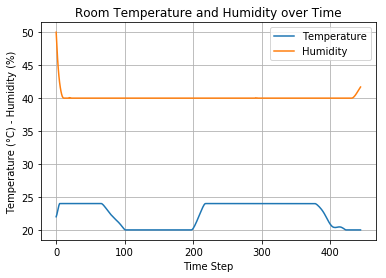

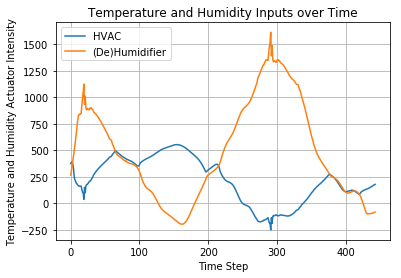

In [67]:
# plot the results
import matplotlib.pyplot as plt
# plot the states
plt.figure(1)
plt.hold = True;
for k in range(mpc_x.shape[1]):
    plt.plot(mpc_x[:,k])
plt.title('Room Temperature and Humidity over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C) - Humidity (%)')
plt.legend(['Temperature','Humidity'])
plt.grid(True)
plt.savefig('MPCstates.svg')

# plot the inputs
plt.figure(2)
plt.hold = True;
for k in range(mpc_u.shape[1]):
    plt.plot(mpc_u[:,k])
plt.title('Temperature and Humidity Inputs over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature and Humidity Actuator Intensity')
plt.legend(['HVAC','(De)Humidifier'])
plt.grid(True)
plt.savefig('MPCinputs.svg')

# show the plots
plt.show()

Congratulations, the system appears to be stable now! Also note that the optimal solution respects your choosen constraints with respect to the control inputs. 